# GxE Data Extraction and Exploration

In [7]:
import datetime
created_date = datetime.datetime.now()
print(f" Script created: {created_date}")

 Script created: 2025-07-01 09:48:30.529153


### 1.1 Initialising spark and load dataset description

In [ ]:
# Import packages 
import dxpy
import dxdata
import pandas as pd
import pyspark

In [ ]:
# Initalising Spark connnection
# Spark initialisation is done only once. do not rerun this cell unless you select kernel ->Restart kernel
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

### Identify and load dispensed dataset ID

In [ ]:
# Automatically discover dispensed dataset ID and load the dataset 
dispensed_dataset = dxpy.find_one_data_object(
    typename='Dataset', 
    name='app*.dataset', 
    folder='/', 
    name_mode='glob')
dispensed_dataset_id = dispensed_dataset['id']
dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [ ]:
dispensed_dataset

### Select entity and load cohort

We will be using the participant entity containing phenotypic data for all 500,000 participants

In [ ]:
participant = dataset['participant']

In [ ]:
import os 
os.chdir('/')

project_id = 'project-Gy3k820J6yzpp320fK2KKGG4'   #
folder_path = '/GxE_dataset/'        # replace with the actual folder path

case = dxdata.load_cohort("GxE_T2D_cases", project=project_id, folder=folder_path)
cont = dxdata.load_cohort("GxE_T2D_controls", project=project_id, folder=folder_path)

### select fields
* Specify field_IDs to retrieve, get corresponding UKB RAP field names and print description table.
* Field Ids can be aquired from the UKB showcase. Care ought to be taken to avoid any mishaps.
* The coding shows an import part of further analysis that

In [ ]:
fields = [
    participant.find_field(name='eid'), # participant ID 
    participant.find_field(name='p21022'), # age at recruitment
    participant.find_field(name='p31'), # sex
    participant.find_field(name='p22001'), # genetic sex
    participant.find_field(name='p21000_i0'), # ethnic background
    participant.find_field(name='p22006'), # genetic ethnic group
    participant.find_field(name='p20160_i0'),  # Eversmoked
    participant.find_field(name='p20116_i0'),  # smoking status
    participant.find_field(name='p6138_i0'),  # qualification
    participant.find_field(name='p1160_i0'),  # sleep duration
    participant.find_field(name='p738_i0'),  # average total household income before tax
    
    participant.find_field(name='p21001_i0'), # BMI
    participant.find_field(name='p23105_i0'), # Basal Metabolic rate
    participant.find_field(name='p22040_i0'), # Summed Metabolic Equivalent Task (MET) minutes per week of all activity
    participant.find_field(name='p48_i0'),# waist circumference
    participant.find_field(name='p49_i0'), # hip circumference
    participant.find_field(name='p21002_i0'), # weight
    participant.find_field(name='p50_i0'), # Standing height
    participant.find_field(name='p1558_i0'), # alcohol intake
    participant.find_field(name='p100002_i0'), # Total energy intake
    participant.find_field(name='p22189'), # townsend deprivation index at recruitment
    participant.find_field(name='p1349_i0'), # processed meat intake 
    participant.find_field(name='p1369_i0'), # beef intake diet
    participant.find_field(name='p1329_i0'), # oily fish intake diet
    participant.find_field(name='p1339_i0'), # Non-oily fish intake
    participant.find_field(name='p1418_i0'), # milk type diet
    participant.find_field(name='p1428_i0'), # spread type diet
    participant.find_field(name='p1448_i0'), # bread type diet
    participant.find_field(name='p1478_i0'), # salt added to food
    participant.find_field(name='p1528_i0'), # water intake diet
    participant.find_field(name='p1309_i0'), # fresh fruit intake diet
    participant.find_field(name='p1289_i0'), # cooked vegetable intake diet
    participant.find_field(name='p20490'),  # sexually molested as a child
    participant.find_field(name='p20488'), # physially abused by family as a child
    participant.find_field(name='p20487'), # felt hated by family member as a child
    participant.find_field(name='p20531'),  # victim of sexual assult
    participant.find_field(name='p20524'),  # sexual interference by partner or ex-partner as an adult
    participant.find_field(name='p20523'),  # physical violence by partner or ex-partner as an adult
    participant.find_field(name='p20521'),  # belittle by partner or ex-partner as an adult
    participant.find_field(name='p41270'), # summary diagnosis - ICD10 
    participant.find_field(name='p26285'), # Standard PRS T2D
    participant.find_field(name='p26286') # Enhanced PRS T2D
]

In [ ]:
field_description = pd.DataFrame({
    'Field': [f.name for f in fields],
    'Title': [f.title for f in fields],
    'Coding': [f.coding.codes if f.coding is not None else '' for f in fields]
})
field_description

In [ ]:
gxe_case_df = participant.retrieve_fields(
    fields = fields, 
    filter_sql = case.sql, 
    engine = dxdata.connect()
).toPandas()

gxe_cont_df = participant.retrieve_fields(
    fields = fields, 
    filter_sql = cont.sql,
    engine= dxdata.connect()
).toPandas()

##### Converting the field entries for `p41270 - Summary Diagnoses ICD10` into binary format, i.e. 
* cases - 1
* controls - 0

In [ ]:
gxe_case_df['p41270'] = 1
gxe_cont_df['p41270'] = 0

##### Adding together the 2 dataframes into one dataframe

In [ ]:
#case_df = case_df.drop(columns='t2d_cc')
#cont_df = cont_df.drop(columns='t2d_cc')

In [ ]:
df = pd.concat([gxe_case_df,gxe_cont_df])

# Environmental data exploration

## 1. Dataset upload

In [1]:
import pandas as pd
df = pd.read_csv("gxe_data.csv", sep = "\t")

In [2]:
df.head()

,eid,p21022,p31,p22001,p21000_i0,p22006,p20160_i0,p20116_i0,p6138_i0,p1160_i0,...,p20490,p20488,p20487,p20531,p20524,p20523,p20521,p41270,p26285,p26286
0,1000011,46,1,1.0,1001.0,1.0,0.0,0.0,[1],7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-0.38477,-0.24085
1,1000962,65,1,1.0,1002.0,NaN,0.0,0.0,"[2, 6]",7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.81098,1.47528
2,1001038,61,1,1.0,1001.0,1.0,1.0,2.0,"[3, 6]",8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.73488,NaN
3,1002326,67,1,1.0,1002.0,NaN,1.0,0.0,[1],7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.71403,0.21527
4,1002955,65,0,0.0,1001.0,1.0,1.0,1.0,[-7],6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.49729,NaN


## Dataset QC

In [3]:
## 1. Sex check (ensuring genetic sex is the same as the reported sex)
df_1 = df[df['p31'] == df['p22001']]

In [4]:
print(f' {df.shape[0] - df_1.shape[0]} individuals were removed after the sex check')

 14598 individuals were removed after the sex check


In [5]:
## 2. keeping only individuals with genetic European and African Ancestries
#### individuals of causasian ancestry are coded "1"
import numpy as np
df_1= df_1.copy()
df_1["pop"] = pd.Series(dtype="object")
df_1.loc[df_1["p22006"] == 1, "pop"] = "EUR"

##using two datasets already estabished to be of African ancestry 
df_AFR_GWAS = pd.read_csv("AFR_GWAS.phe", sep="\t")
df_AFR_PRS = pd.read_csv("AFR_PRS.phe", sep="\t")
df_AFR = pd.concat([df_AFR_GWAS,df_AFR_PRS])
df_AFR = df_AFR[["FID", "IID", "t2d_cc"]]

df_1.loc[df_1["eid"].isin(df_AFR["FID"]), "pop"] = "AFR"


In [7]:
df_1['pop'].value_counts(dropna=False)

pop
EUR    409049
NaN     70063
AFR      8418
Name: count, dtype: int64

keeping only individuals of African and European ancestry

In [8]:
df_2 = df_1[df_1['pop'].notna()]

In [9]:
df_2.shape

(417467, 43)

In [10]:
## 3.  removing columns `p100002_i0 - total energy intake` and `p26286 - Enhanced PRS for T2D` and those that are no longer required for further analysis
df_3 = df_2.drop(columns=['p100002_i0', 'p26286', 'p22001','p21000_i0','p22006', 'p6138_i0'])

## Data Exploration and Calculating extra features

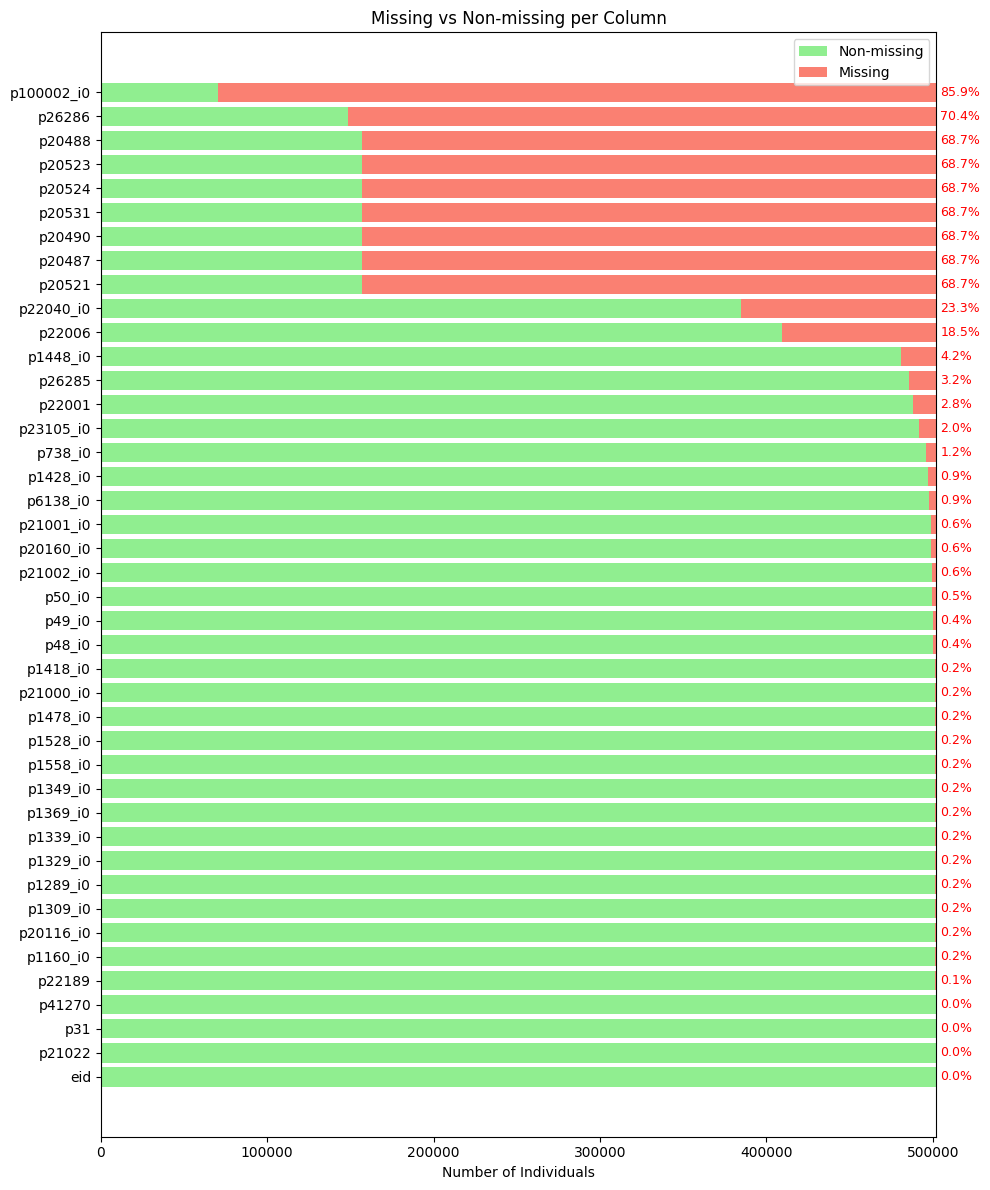

In [5]:
## visualising the missing values in the dataset
import matplotlib.pyplot as plt

# Total number of rows
n_total = len(env_data)

# Get counts of missing and non-missing for each column
missing = env_data.isnull().sum()
non_missing = n_total - missing

# Combine into a DataFrame
missing_df = pd.DataFrame({
    'Missing': missing,
    'Non-missing': non_missing
})

# Sort by % missing
missing_df['% Missing'] = (missing_df['Missing'] / n_total) * 100
missing_df = missing_df.sort_values('% Missing', ascending=True)

# Plot
plt.figure(figsize=(10, 12))
bars_nonmissing = plt.barh(missing_df.index, missing_df['Non-missing'], color='lightgreen', label='Non-missing')
bars_missing = plt.barh(missing_df.index, missing_df['Missing'], left=missing_df['Non-missing'], color='salmon', label='Missing')

# Add missing % text labels to the right of each bar
for i, (total, missing_val, percent) in enumerate(zip(missing_df['Non-missing'] + missing_df['Missing'],
                                                       missing_df['Missing'],
                                                       missing_df['% Missing'])):
    plt.text(total + n_total*0.005,  # small space after the end of the bar
             i, 
             f"{percent:.1f}%", 
             va='center', 
             fontsize=9, 
             color='red')

plt.xlabel("Number of Individuals")
plt.title("Missing vs Non-missing per Column")
plt.legend()
plt.tight_layout()
plt.show()


We'll drop columns `p100002_i0 - total energy intake` and `p26286 - Enhanced PRS for T2D` and all rows with any missing values from further analysis

In [10]:
print(f'removing all NaN values the dataset with {env_data_clean.shape[0]} individuals')

removing all NaN values the dataset with 121006 individuals


### 1. Calculating Waist-Hip Ratio

In [12]:
#calculation whr
# "p48_i0":"waist", "p49_i0":"hip"
df_3['whr'] = df_3['p48_i0'] / df_3['p49_i0']

### 2. Creating the childhood trauma score
A childhood trauma score was be derived from three Field IDs from the UK Biobank where participants were asked whether they were 
1. `p20488` “physically abused by family as a child”, 
2. `p20490` “sexually molested as a child” 
3. `p20487` “felt hated by family member as a child”

based on the paper Dalvie et al., 2020 https://www.nature.com/articles/s41398-020-0706-0 

### Trauma Score 1: A sum of the following three items (score range 0-3):


Field ID Description Category Numbers Description of dichotomisation


<table border="1" cellpadding="6" cellspacing="0">
  <thead>
    <tr>
      <th><b>Field ID</b></th>
      <th><b>Description</b></th>
      <th><b>Category</b></th>
      <th><b>Description of Dichotomisation</b></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>p20488</td>
      <td>Physically abused by family as a child</td>
      <td>Physical Abuse</td>
      <td>
        Physical abuse is considered present with responses:<br>
        <b>Sometimes True</b>, <b>Often</b>, <b>Very Often True</b>
      </td>
    </tr>
    <tr>
      <td>p20487</td>
      <td>Felt hated by family member as a child</td>
      <td>Emotional Abuse</td>
      <td>
        Emotional abuse is considered present with responses:<br>
        <b>Often</b>, <b>Very Often True</b>
      </td>
    </tr>
    <tr>
      <td>p20490</td>
      <td>Sexually molested as a child</td>
      <td>Sexual Abuse</td>
      <td>
        Sexual abuse is considered present with responses:<br>
        <b>Sometimes True</b>, <b>Often</b>, <b>Very Often True</b>
      </td>
    </tr>
  </tbody>
</table>


<div style="text-align: center;">
  <img src="childhood_questionaire.png" width="400">
</div>

In [15]:
## assigning 'nan' to individuals that responded "prefer not to answer" which is coded as '-818'
cmcs_cols = ['p20490', 'p20488', 'p20487']
df_3[cmcs_cols] = df_3[cmcs_cols].replace(-818.0, np.nan)

In [19]:
df_3['p20490'].value_counts(dropna=False)

p20490
NaN    285503
0.0    120951
1.0      5831
2.0      3997
3.0       659
4.0       526
Name: count, dtype: int64

In [25]:
# import numpy as np
# import pandas as pd

# Define column-specific maltreatment levels
cmsc_maltreatment_levels_map = {
    'p20487': [3.0, 4.0],               # Emotional abuse
    'p20488': [2.0, 3.0, 4.0],          # Physical abuse
    'p20490': [2.0, 3.0, 4.0]           # Sexual abuse
}

def calculate_cmcs(data, maltreatment_map):
    """
    Calculate Childhood Maltreatment Count Score (CMCS) from specified columns,
    preserving NaN values in the original data.
    
    Parameters:
    - data: pandas DataFrame containing the relevant columns
    - maltreatment_map: dictionary mapping column names to lists of values that indicate maltreatment
    
    Returns:
    - Series containing the CMCS scores (with NaN where any input was NaN)
    """
        # Initialize with all NaN values
    cmcs = pd.Series(np.nan, index=data.index)
        # Create a mask to track rows with any NaN values
    nan_mask = data[list(maltreatment_map.keys())].isna().any(axis=1)
        # Initialize score for non-NaN rows
    score = pd.Series(0, index=data.index)
    
    for column, levels in maltreatment_map.items():
        if column in data.columns:
            # Add 1 to score if value is in the maltreatment levels for this column
            score += data[column].isin(levels).astype(int)
        else:
            raise ValueError(f"Column {column} not found in data")
    
    # Apply the scores only to rows without any NaN values
    cmcs[~nan_mask] = score[~nan_mask]
    
    return cmcs

In [26]:
df_3['cmcs'] = calculate_cmcs(df_3, cmsc_maltreatment_levels_map)

In [27]:
df_3.head()

,eid,p21022,p31,p20160_i0,p20116_i0,p1160_i0,p738_i0,p21001_i0,p23105_i0,p22040_i0,...,p20487,p20531,p20524,p20523,p20521,p41270,p26285,pop,whr,cmcs
0,1000011,46,1,0.0,0.0,7.0,1.0,39.0082,11795.0,1000.0,...,NaN,NaN,NaN,NaN,NaN,1,-0.38477,EUR,1.065041,NaN
2,1001038,61,1,1.0,2.0,8.0,3.0,24.7128,7477.0,1390.5,...,NaN,NaN,NaN,NaN,NaN,1,1.73488,EUR,0.871287,NaN
4,1002955,65,0,1.0,1.0,6.0,2.0,30.5594,6017.0,996.0,...,NaN,NaN,NaN,NaN,NaN,1,1.49729,EUR,0.911504,NaN
5,1003669,69,1,1.0,2.0,7.0,1.0,22.8984,5832.0,693.0,...,2.0,0.0,0.0,0.0,0.0,1,-0.52105,EUR,0.958333,2.0
6,1003937,65,1,1.0,1.0,6.0,2.0,27.3868,7699.0,3625.5,...,0.0,0.0,0.0,0.0,0.0,1,0.03604,EUR,0.940594,0.0


In [29]:
df_3['cmcs'].value_counts(dropna=False)

cmcs
NaN    285925
0.0    116566
1.0     12025
2.0      2479
3.0       472
Name: count, dtype: int64

#### visualising the childhood maltreatment count score

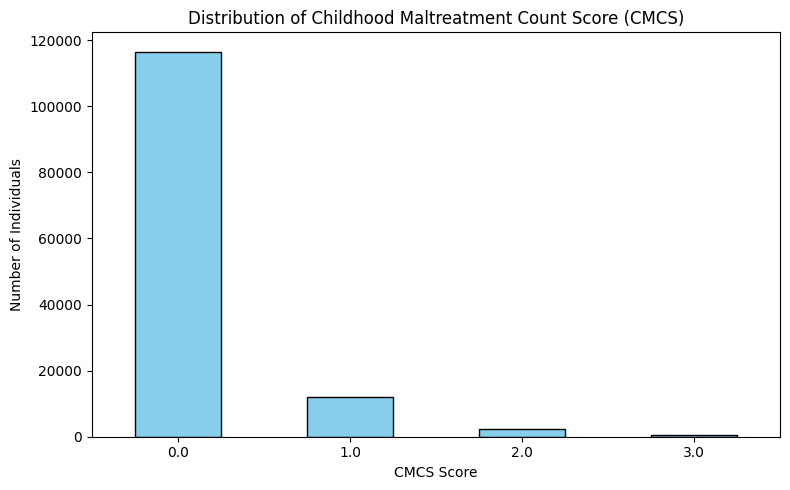

In [32]:
# Count values (excluding NaN)
counts = df_3['cmcs'].value_counts().sort_index()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Childhood Maltreatment Count Score (CMCS)")
plt.xlabel("CMCS Score")
plt.ylabel("Number of Individuals")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

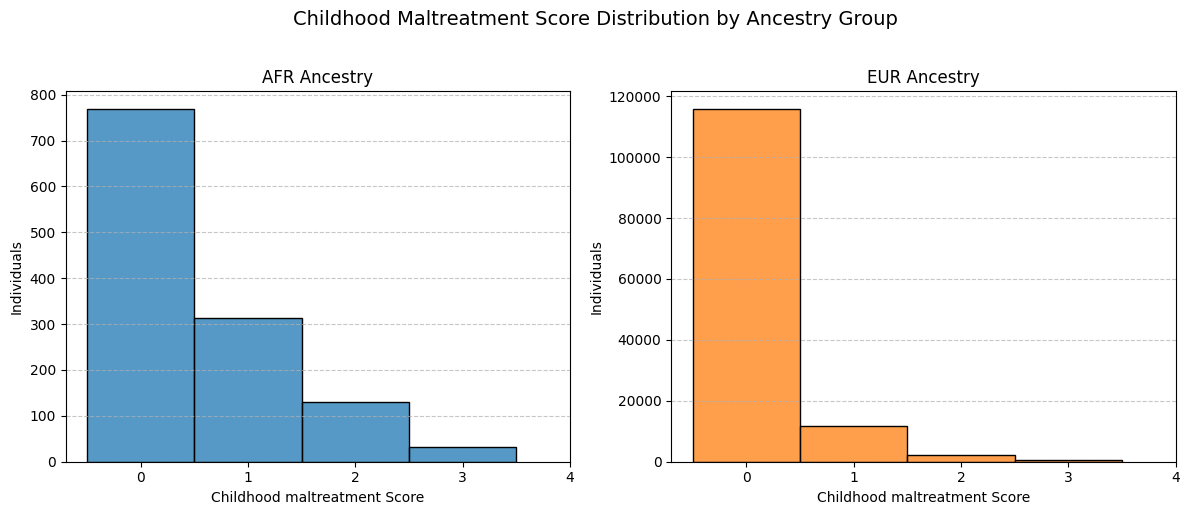

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset data
afr_data_cmsc = df_3[df_3["pop"] == "AFR"]
eur_data_cmsc = df_3[df_3["pop"] == "EUR"]

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# AFR Histogram
bins = np.arange(-0.5, 4.5, 1)

sns.histplot(
    data=afr_data_cmsc,
    x="cmcs",
    bins=bins,
    ax=axes[0],
    color="#1f77b4",
    edgecolor="black"
)
axes[0].set_title("AFR Ancestry")
axes[0].set_xlabel("Childhood maltreatment Score")
axes[0].set_ylabel("Individuals")
axes[0].set_xticks(range(0, 10))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# EUR Histogram
sns.histplot(
    data=eur_data_cmsc,
    x="cmcs",
    bins=bins,
    ax=axes[1],
    color="#ff7f0e",
    edgecolor="black"
)
axes[1].set_title("EUR Ancestry")
axes[1].set_xlabel("Childhood maltreatment Score")
axes[1].set_ylabel("Individuals")
axes[1].set_xticks(range(0, 5))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Childhood Maltreatment Score Distribution by Ancestry Group", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 3. Calculating Intimate Partner Violence Score (`ipvs`)
An IPV score was be derived from four Field IDs from the UK Biobank dataset in where participants were asked whether as an adult, they were 
1. `p20521` “repeatedly belittled by a partner or ex-partner to the extent that they felt worthless”, 
2. `p20523` “physically abused by a partner or an ex-partner” 
3. `p20524` “sexually interfered with or forced to have sex” 
4. `p20531` “a victim of sexual assault” 

based on the papers Yapp et al., 2023 https://pmc.ncbi.nlm.nih.gov/articles/PMC10628045/, https://pmc.ncbi.nlm.nih.gov/articles/PMC10632932/, https://pmc.ncbi.nlm.nih.gov/articles/PMC10632932/ 

<div style="text-align: center;">
  <img src="ipv_questionaire.png" width="400">
</div>

### Trauma Score 1: A sum of the following three items (score range 0-3):


Field ID Description Category Numbers Description of dichotomisation


<table border="1" cellpadding="6" cellspacing="0">
  <thead>
    <tr>
      <th><b>Field ID</b></th>
      <th><b>Description</b></th>
      <th><b>Category</b></th>
      <th><b>Description of Dichotomisation</b></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>p20523</td>
      <td>Physically abused by family as a child</td>
      <td>Physical Abuse</td>
      <td>
        Physical abuse is considered present with responses:<br>
        <b>Sometimes True</b>, <b>Often</b>, <b>Very Often True</b>
      </td>
    </tr>
    <tr>
      <td>p20521</td>
      <td>repeatedly belittled by a partner or ex-partner to the extent that they felt worthless</td>
      <td>Emotional Abuse</td>
      <td>
        Emotional abuse is considered present with responses:<br>
        <b>Often</b>, <b>Very Often True</b>
      </td>
    </tr>
    <tr>
      <td>p20524</td> 
      <td>sexually interfered with or forced to have sex</td>
      <td>Sexual Abuse</td>
      <td>
        Sexual abuse is considered present with responses:<br>
        <b>Sometimes True</b>, <b>Often</b>, <b>Very Often True</b>
      </td>
    </tr>
    <tr>
      <td>p20531</td>
      <td>a victim of sexual assault</td>
      <td>Sexual Abuse</td>
      <td>
        Sexual abuse is considered present with responses:<br>
        <b>Sometimes True</b>, <b>Often</b>, <b>Very Often True</b>
      </td>
    </tr>
  </tbody>
</table>

In [34]:
df_3['p20524'].value_counts(dropna=False)

p20524
 NaN      283993
 0.0      125722
 1.0        4057
 2.0        2480
 4.0         428
-818.0       405
 3.0         382
Name: count, dtype: int64

In [35]:
## assigning 'nan' to individuals that responded "prefer not to answer" which is coded as '-818'

ipvs_cols = ['p20521', 'p20523', 'p20524','p20531']
df_3[ipvs_cols] = df_3[ipvs_cols].replace(-818.0, np.nan)

In [36]:
## import numpy as np
## import pandas as pd

# Define column-specific maltreatment levels
ipvs_maltreatment_levels_map = {
    'p20521': [3.0, 4.0],               # Emotional abuse
    'p20523': [2.0, 3.0, 4.0],          # Physical abuse
    'p20524': [2.0, 3.0, 4.0],           # Sexual abuse
    'p20531': [2.0, 3.0, 4.0]            # Sexual abuse
}

# using the function "calculate_cmcs" to calculate the ipvs
df_3['ipvs'] = calculate_cmcs(df_3, ipvs_maltreatment_levels_map)


In [37]:
df_3.head()

,eid,p21022,p31,p20160_i0,p20116_i0,p1160_i0,p738_i0,p21001_i0,p23105_i0,p22040_i0,...,p20531,p20524,p20523,p20521,p41270,p26285,pop,whr,cmcs,ipvs
0,1000011,46,1,0.0,0.0,7.0,1.0,39.0082,11795.0,1000.0,...,NaN,NaN,NaN,NaN,1,-0.38477,EUR,1.065041,NaN,NaN
2,1001038,61,1,1.0,2.0,8.0,3.0,24.7128,7477.0,1390.5,...,NaN,NaN,NaN,NaN,1,1.73488,EUR,0.871287,NaN,NaN
4,1002955,65,0,1.0,1.0,6.0,2.0,30.5594,6017.0,996.0,...,NaN,NaN,NaN,NaN,1,1.49729,EUR,0.911504,NaN,NaN
5,1003669,69,1,1.0,2.0,7.0,1.0,22.8984,5832.0,693.0,...,0.0,0.0,0.0,0.0,1,-0.52105,EUR,0.958333,2.0,0.0
6,1003937,65,1,1.0,1.0,6.0,2.0,27.3868,7699.0,3625.5,...,0.0,0.0,0.0,0.0,1,0.03604,EUR,0.940594,0.0,0.0


In [39]:
df_3['ipvs'].value_counts(dropna=False)

ipvs
NaN    286229
0.0    119495
1.0      7721
2.0      2798
3.0      1215
4.0         9
Name: count, dtype: int64

#### Visualising the Intimate Partner Violence Count score

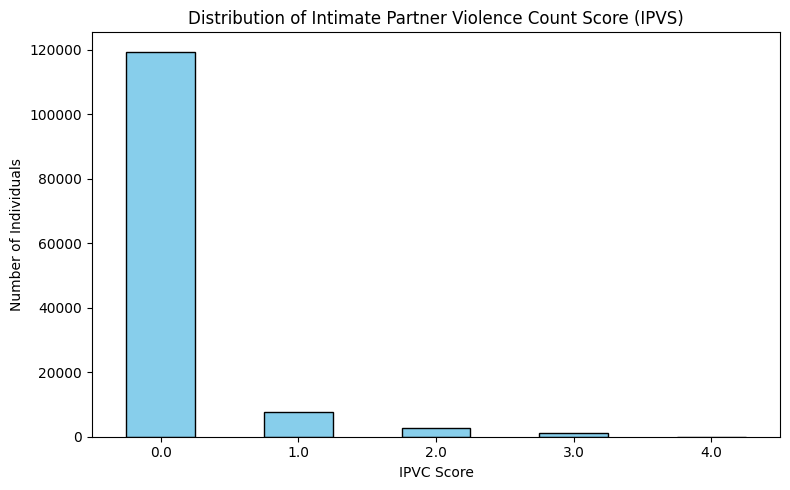

In [40]:
# Count values (excluding NaN)
counts = df_3['ipvs'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Intimate Partner Violence Count Score (IPVS)")
plt.xlabel("IPVC Score")
plt.ylabel("Number of Individuals")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

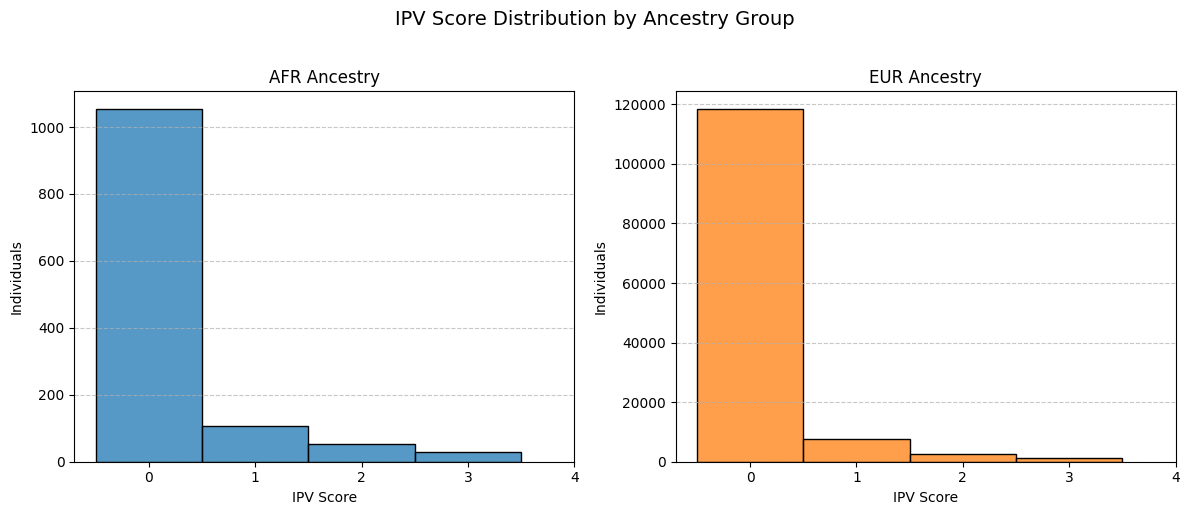

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset data
afr_data = df_3[df_3["pop"] == "AFR"]
eur_data = df_3[df_3["pop"] == "EUR"]

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# AFR Histogram
bins = np.arange(-0.5, 4.5, 1)

sns.histplot(
    data=afr_data,
    x="ipvs",
    bins=bins,
    ax=axes[0],
    color="#1f77b4",
    edgecolor="black"
)
axes[0].set_title("AFR Ancestry")
axes[0].set_xlabel("IPV Score")
axes[0].set_ylabel("Individuals")
axes[0].set_xticks(range(0, 10))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# EUR Histogram
sns.histplot(
    data=eur_data,
    x="ipvs",
    bins=bins,
    ax=axes[1],
    color="#ff7f0e",
    edgecolor="black"
)
axes[1].set_title("EUR Ancestry")
axes[1].set_xlabel("IPV Score")
axes[1].set_ylabel("Individuals")
axes[1].set_xticks(range(0, 5))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("IPV Score Distribution by Ancestry Group", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 4. Calculating the Diet score

Using https://www.frontiersin.org/journals/nutrition/articles/10.3389/fnut.2024.1349538/full
(Carrasco-Marín et al., 2024) 
11 food items were used to calculate a cummulated diet score
 

<table>
  <thead>
    <tr>
      <th>UKB Field ID</th>
      <th>Diet Component</th>
      <th>UKB Field Description</th>
      <th>Healthy Condition (Score = 1)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>p1349_i0</td>
      <td><strong>Processed meat</strong></td>
      <td>processed meat intake</td>
      <td>Less than once/week ("never", "less than once a week")</td>
    </tr>
    <tr>
      <td>p1369_i0</td>
      <td><strong>Red meat</strong></td>
      <td>beef intake</td>
      <td>Less than once/week</td>
    </tr>
    <tr>
      <td>p1329_i0, p1339_i0 </td>
      <td><strong>Fish intake (total)</strong></td>
      <td>Oily fish intake, non-oily fish intake</td>
      <td>Combined &gt; 2 times/week</td>
    </tr>
    <tr>
      <td>p1418_i0</td>
      <td><strong>Milk type</strong></td>
      <td>Milk type used</td>
      <td>"semi-skimmed"or "skimmed"</td>
    </tr>
    <tr>
      <td>p1428_i0</td>
      <td><strong>Spread type</strong></td>
      <td>spread type</td>
      <td>Low-fat options (e.g. "low-fat margarine", "flora")</td>
    </tr>
    <tr>
      <td>p1448_i0</td>
      <td><strong>Cereal substitute </strong></td>
      <td>bread type</td>
      <td>Replace with whole grain bread maybe </td>
    </tr>
    <tr>
      <td>p1478_i0</td>
      <td><strong>Salt added to food</strong></td>
      <td>Salt added at table</td>
      <td>"never", "rarely"</td>
    </tr>
    <tr>
      <td>p1528_i0</td>
      <td><strong>Water intake</strong></td>
      <td>Water glasses per day</td>
      <td>&gt; 6 glasses per day</td>
    </tr>
    <tr>
      <td>p1309_i0, p1289_i0</td>
      <td><strong>Fruit & vegetables</strong></td>
      <td>Fresh fruit intake diet, cooked vegetable intake</td>
      <td>Combined &gt; 5/day</td>
    </tr>
  </tbody>
</table>


In [44]:
## Calculating the diet score
#import pandas as pd
#import numpy as np

def compute_diet_score(df):
    """
    Compute a 9-point diet score based on UK Biobank dietary data.
    Rules:
        - Each healthy component = 1 point (max 9 points).
        - Special codes (-1, -3, -10) are treated as missing.
        - If any component is missing, the total score is NaN.
    """
    score = pd.Series(0, index=df.index)  # Initialize score
    
    # Define special codes to exclude
    SPECIAL_CODES = [-1, -3, -10]
    
    # 1. Fruit & vegetables (>5 servings/day)
    mask_fruit_veg = ~df[['p1309_i0', 'p1289_i0']].isin(SPECIAL_CODES).any(axis=1) & \
                    ~df[['p1309_i0', 'p1289_i0']].isna().any(axis=1)
    fruit_veg = (df['p1309_i0'] + df['p1289_i0']) > 5
    score += np.where(mask_fruit_veg, fruit_veg.astype(int), 0)
    
    # 2. Processed meat (Never [0] or <1/week [1])
    mask_proc_meat = ~df['p1349_i0'].isin(SPECIAL_CODES) & ~df['p1349_i0'].isna()
    proc_meat = df['p1349_i0'].isin([0, 1])
    score += np.where(mask_proc_meat, proc_meat.astype(int), 0)
    
    # 3. Red meat (Never [0] or <1/week [1])
    mask_red_meat = ~df['p1369_i0'].isin(SPECIAL_CODES) & ~df['p1369_i0'].isna()
    red_meat = df['p1369_i0'].isin([0, 1])
    score += np.where(mask_red_meat, red_meat.astype(int), 0)
    
    # 4. Fish (>2 times/week, combined oily + non-oily)
    mask_fish = ~df[['p1329_i0', 'p1339_i0']].isin(SPECIAL_CODES).any(axis=1) & \
               ~df[['p1329_i0', 'p1339_i0']].isna().any(axis=1)
    fish = (df['p1329_i0'] + df['p1339_i0']) > 2
    score += np.where(mask_fish, fish.astype(int), 0)
    
    # 5. Milk type (Semi-skimmed [2] or skimmed [3])
    mask_milk = ~df['p1418_i0'].isin(SPECIAL_CODES) & ~df['p1418_i0'].isna()
    milk = df['p1418_i0'].isin([2, 3])
    score += np.where(mask_milk, milk.astype(int), 0)
    
    # 6. Spread type (Flora/Benecol [2] or never use spread [0])
    mask_spread = ~df['p1428_i0'].isin(SPECIAL_CODES) & ~df['p1428_i0'].isna()
    spread = df['p1428_i0'].isin([0, 2])
    score += np.where(mask_spread, spread.astype(int), 0)
    
    # 7. Bread type (Wholemeal [3] or Brown [2] - adjust per your criteria)
    mask_bread = ~df['p1448_i0'].isin(SPECIAL_CODES) & ~df['p1448_i0'].isna()
    bread = df['p1448_i0'].isin([2, 3])  # 2=Brown, 3=Wholemeal
    score += np.where(mask_bread, bread.astype(int), 0)
    
    # 8. Salt added (Never/rarely [1])
    mask_salt = ~df['p1478_i0'].isin(SPECIAL_CODES) & ~df['p1478_i0'].isna()
    salt = df['p1478_i0'] == 1
    score += np.where(mask_salt, salt.astype(int), 0)
    
    # 9. Water (>6 glasses/day)
    mask_water = ~df['p1528_i0'].isin(SPECIAL_CODES) & ~df['p1528_i0'].isna()
    water = df['p1528_i0'] > 6
    score += np.where(mask_water, water.astype(int), 0)
    
    # Set score to NaN if any component is invalid
    diet_cols = ['p1309_i0', 'p1289_i0', 'p1349_i0', 'p1369_i0', 
                 'p1329_i0', 'p1339_i0', 'p1418_i0', 'p1428_i0', 
                 'p1448_i0', 'p1478_i0', 'p1528_i0']
    invalid_mask = (
        df[diet_cols].isin(SPECIAL_CODES).any(axis=1) |
        df[diet_cols].isna().any(axis=1)
    )
    score[invalid_mask] = np.nan
    
    return score

In [45]:
df_3['diet_score'] = compute_diet_score(df_3)

In [46]:
df_3.head()

,eid,p21022,p31,p20160_i0,p20116_i0,p1160_i0,p738_i0,p21001_i0,p23105_i0,p22040_i0,...,p20524,p20523,p20521,p41270,p26285,pop,whr,cmcs,ipvs,diet_score
0,1000011,46,1,0.0,0.0,7.0,1.0,39.0082,11795.0,1000.0,...,NaN,NaN,NaN,1,-0.38477,EUR,1.065041,NaN,NaN,4.0
2,1001038,61,1,1.0,2.0,8.0,3.0,24.7128,7477.0,1390.5,...,NaN,NaN,NaN,1,1.73488,EUR,0.871287,NaN,NaN,NaN
4,1002955,65,0,1.0,1.0,6.0,2.0,30.5594,6017.0,996.0,...,NaN,NaN,NaN,1,1.49729,EUR,0.911504,NaN,NaN,6.0
5,1003669,69,1,1.0,2.0,7.0,1.0,22.8984,5832.0,693.0,...,0.0,0.0,0.0,1,-0.52105,EUR,0.958333,2.0,0.0,2.0
6,1003937,65,1,1.0,1.0,6.0,2.0,27.3868,7699.0,3625.5,...,0.0,0.0,0.0,1,0.03604,EUR,0.940594,0.0,0.0,4.0


In [47]:
df_3['diet_score'].value_counts(dropna=False)

diet_score
4.0    85840
5.0    81722
NaN    67449
3.0    62361
6.0    52434
2.0    30730
7.0    21666
1.0     9148
8.0     4585
0.0     1164
9.0      368
Name: count, dtype: int64

In [56]:
"""
import pandas as pd
import numpy as np

# --- Mapping for fish frequency from UKB codes ---
fish_freq_map = {
    0: 0,     # Never
    1: 0.5,   # Less than once a week
    2: 1,     # Once a week
    3: 3,     # 2-4 times a week
    4: 5.5,   # 5-6 times a week
    5: 7,     # Once or more daily
}

# --- Calculate diet score ---
ipvc_data_clean["diet_score"] = (
    # 1. Processed meat intake (p1349_i0): codes 0,1
    ipvc_data_clean["p1349_i0"].isin([0, 1]).astype(int) +

    # 2. Red meat / beef intake (p1369_i0): codes 0,1
    ipvc_data_clean["p1369_i0"].isin([0, 1]).astype(int) +

    # 3. Total fish intake (oily + non-oily): combined > 2 times/week
    ((ipvc_data_clean["p1329_i0"].map(fish_freq_map).fillna(0) +
      ipvc_data_clean["p1339_i0"].map(fish_freq_map).fillna(0)) > 2).astype(int) +

    # 4. Milk type (p1418_i0): semi-skimmed (2) or skimmed (3)
    ipvc_data_clean["p1418_i0"].isin([2, 3]).astype(int) +

    # 5. Spread type (p1428_i0): Flora/Benecol (2) or Never/rarely (0)
    ipvc_data_clean["p1428_i0"].isin([0, 2]).astype(int) +

    # 6. Bread type (p1448_i0): wholemeal (1), wholegrain (6)
    ipvc_data_clean["p1448_i0"].isin([1, 6]).astype(int) +

    # 7. Salt added to food (p1478_i0): Never/rarely = 1
    (ipvc_data_clean["p1478_i0"] == 1).astype(int) +

    # 8. Water intake (p1528_i0): > 6 glasses/day
    pd.to_numeric(ipvc_data_clean["p1528_i0"], errors="coerce").gt(6).astype(int) +

    # 9. Fruit & veg (p1309_i0 + p1289_i0): total servings > 5/day
    (
        pd.to_numeric(ipvc_data_clean["p1309_i0"], errors="coerce").fillna(0) +
        pd.to_numeric(ipvc_data_clean["p1289_i0"], errors="coerce").fillna(0)
    ).gt(5).astype(int)
)
"""

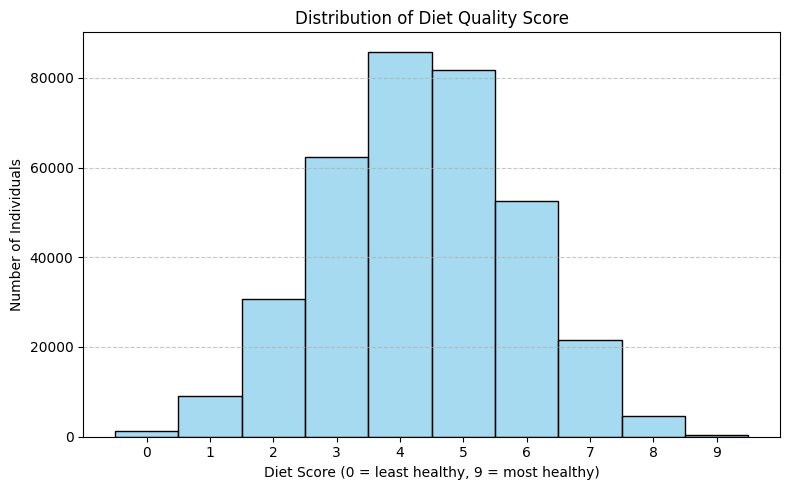

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_3["diet_score"], bins=np.arange(-0.5, 10.5, 1), kde=False, color="skyblue", edgecolor="black")
plt.title("Distribution of Diet Quality Score")
plt.xlabel("Diet Score (0 = least healthy, 9 = most healthy)")
plt.ylabel("Number of Individuals")
plt.xticks(range(0, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


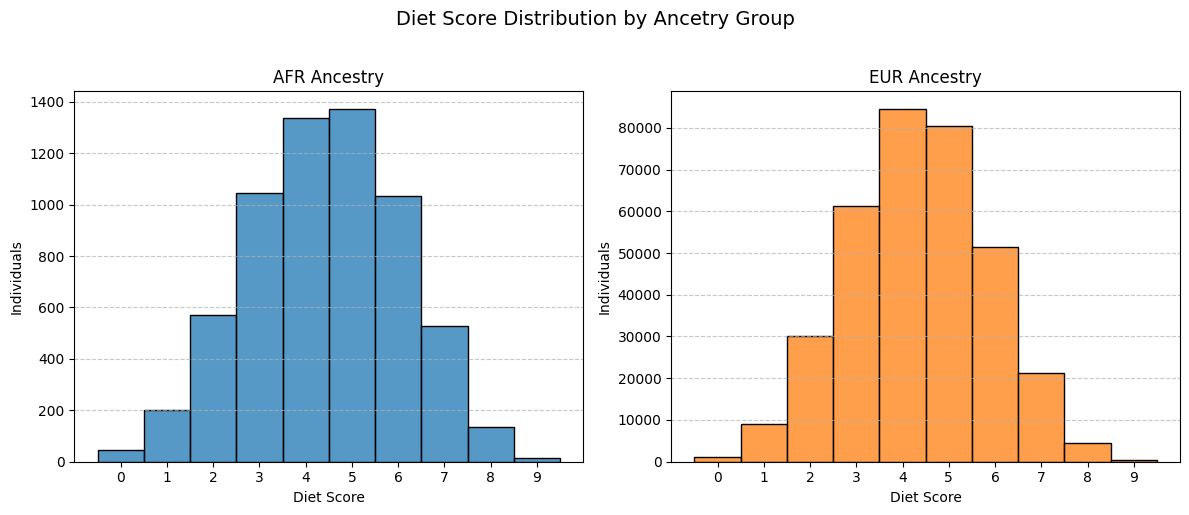

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset data
afr_data = df_3[df_3["pop"] == "AFR"]
eur_data = df_3[df_3["pop"] == "EUR"]

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# AFR Histogram
bins = np.arange(-0.5, 10.5, 1)

sns.histplot(
    data=afr_data,
    x="diet_score",
    bins=bins,
    ax=axes[0],
    color="#1f77b4",
    edgecolor="black"
)
axes[0].set_title("AFR Ancestry")
axes[0].set_xlabel("Diet Score")
axes[0].set_ylabel("Individuals")
axes[0].set_xticks(range(0, 10))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# EUR Histogram
sns.histplot(
    data=eur_data,
    x="diet_score",
    bins=bins,
    ax=axes[1],
    color="#ff7f0e",
    edgecolor="black"
)
axes[1].set_title("EUR Ancestry")
axes[1].set_xlabel("Diet Score")
axes[1].set_ylabel("Individuals")
axes[1].set_xticks(range(0, 10))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Diet Score Distribution by Ancetry Group", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### 5. Age Distribution

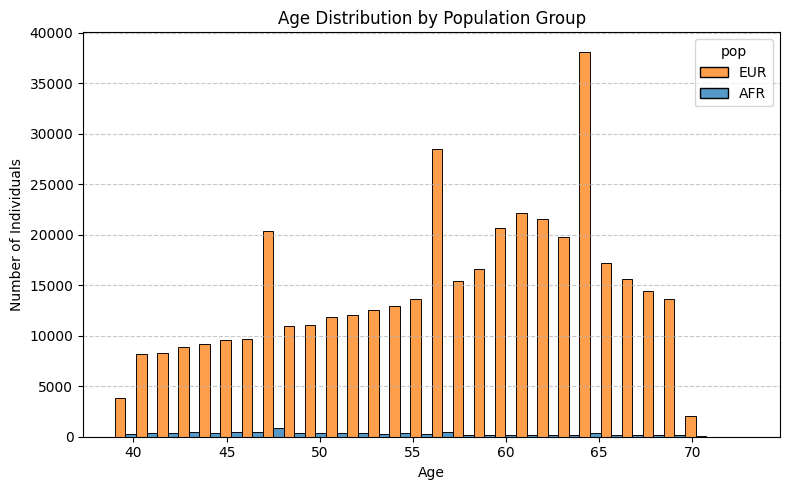

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_3,
    x="p21022",  # replace with correct age column if named differently
    hue="pop",
    bins=30,
    multiple="dodge",
    edgecolor="black",
    palette={"AFR": "#1f77b4", "EUR": "#ff7f0e"}
)
plt.title("Age Distribution by Population Group")
plt.xlabel("Age")
plt.ylabel("Number of Individuals")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


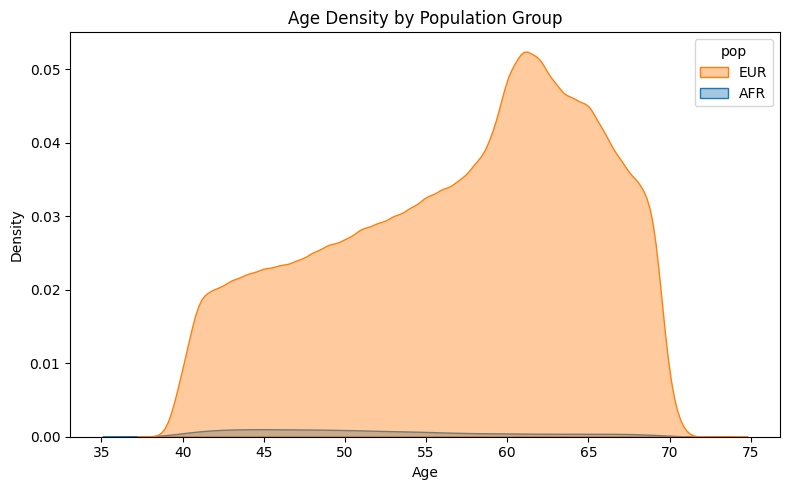

In [51]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_3,
    x="p21022",
    hue="pop",
    fill=True,
    alpha=0.4,
    palette={"AFR": "#1f77b4", "EUR": "#ff7f0e"}
)
plt.title("Age Density by Population Group")
plt.xlabel("Age")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


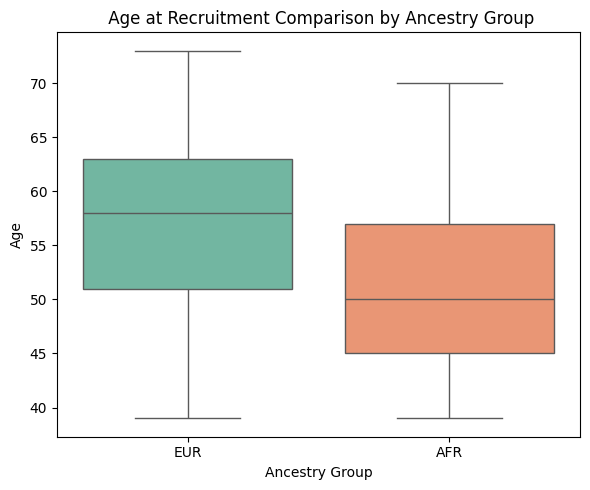

In [53]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_3, x="pop", y="p21022", palette="Set2", hue="pop")
plt.title(" Age at Recruitment Comparison by Ancestry Group")
plt.xlabel("Ancestry Group")
plt.ylabel("Age")
plt.tight_layout()
plt.show()


### 6. Townsend Score

Area-based deprivation was measured by the Townsend score, which was derived from census data on housing, employment, social class, and car availability by postcode of residence.

A higher Townsend score represents a higher level of deprivation. 
individuals with higher deprivation showed a higher associations to T2D according to https://dom-pubs.pericles-prod.literatumonline.com/doi/10.1111/dom.15190 and https://www.sciencedirect.com/science/article/pii/S0002934325002827?via%3Dihub

In [68]:
ipvc_data_clean['p22189'].value_counts()

p22189
-4.52    400
-4.11    381
-3.96    369
-3.53    358
-3.70    355
        ... 
 8.76      1
 8.98      1
 9.00      1
 9.58      1
 8.84      1
Name: count, Length: 1501, dtype: int64

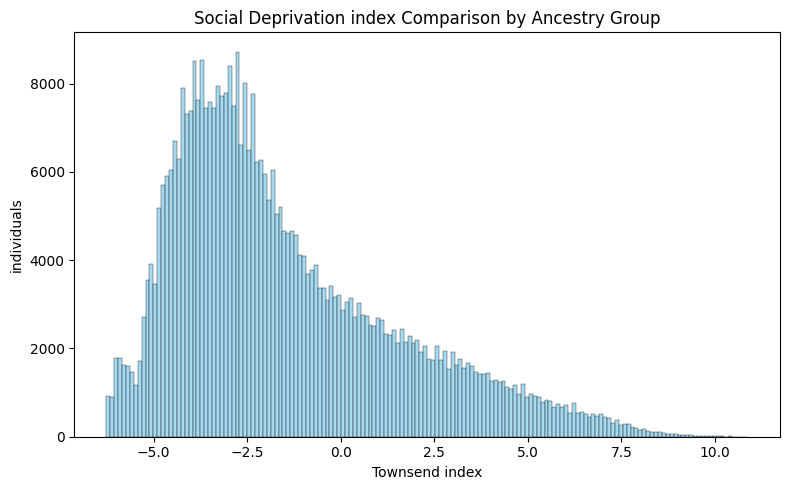

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_3["p22189"], kde=False, color="skyblue", edgecolor="black")
plt.title("Social Deprivation index Comparison by Ancestry Group")
plt.xlabel("Townsend index")
plt.ylabel("individuals")
plt.tight_layout()
plt.show()


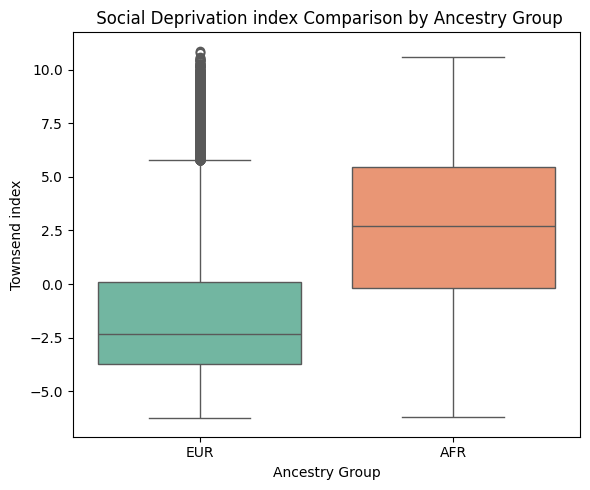

In [60]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_3, x="pop", y="p22189", palette="Set2", hue="pop")
plt.title(" Social Deprivation index Comparison by Ancestry Group")
plt.xlabel("Ancestry Group")
plt.ylabel("Townsend index")
plt.tight_layout()
plt.show()

### 7. Sleep duration

Participants were asked  a question `About how many hours sleep do you get in every 24 hours? (please include naps)`

In [61]:
## 
import numpy as np
df_3['p1160_i0'] = df_3['p1160_i0'].replace([-3, -1], np.nan)

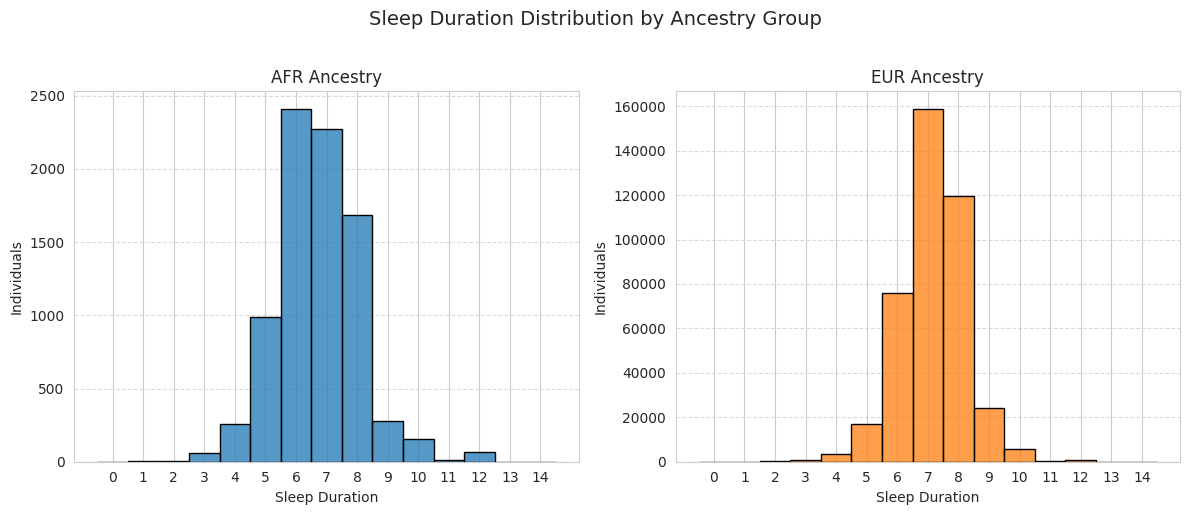

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset data
afr_data = df_3[df_3["pop"] == "AFR"]
eur_data = df_3[df_3["pop"] == "EUR"]

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# AFR Histogram
bins = np.arange(-0.5, 15.5, 1)

sns.histplot(
    data=afr_data,
    x="p1160_i0",
    bins=bins,
    ax=axes[0],
    color="#1f77b4",
    edgecolor="black"
)
axes[0].set_title("AFR Ancestry")
axes[0].set_xlabel("Sleep Duration")
axes[0].set_ylabel("Individuals")
axes[0].set_xticks(range(0, 10))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# EUR Histogram
sns.histplot(
    data=eur_data,
    x="p1160_i0",
    bins=bins,
    ax=axes[1],
    color="#ff7f0e",
    edgecolor="black"
)
axes[1].set_title("EUR Ancestry")
axes[1].set_xlabel("Sleep Duration")
axes[1].set_ylabel("Individuals")
axes[1].set_xticks(range(0, 15))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Sleep Duration Distribution by Ancestry Group", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### 8. Physical Activity

Total Metabolic Equivalent Task (MET) minutes per week for all activity including walking, moderate and vigorous activity score data was derived according to International Physical Activity Questionnaire (IPAQ) guidelines.

Using the Ainsworth et al. Compendium (Med Sci Sports Med 2000) an average MET score was derived for each type of
activity. For example; all types of walking were included and an average MET value for walking was created. The same procedure was undertaken for moderate-intensity activities and vigorous-intensity activities. The following values continue to be used for the analysis of IPAQ data: Walking = 3.3 METs, Moderate PA = 4.0 METs and
Vigorous PA = 8.0 METs. 

Using these values, four continuous scores are defined:
* Walking MET-minutes/week = 3.3 * walking minutes * walking days
* Moderate MET-minutes/week = 4.0 * moderate-intensity activity minutes * moderate days
* Vigorous MET-minutes/week = 8.0 * vigorous-intensity activity minutes * vigorous-intensity days
* <strong>Total physical activity MET-minutes/week = sum of Walking + Moderate + Vigorous MET-minutes/week scores.</strong> 

In [81]:
df_3['p22040_i0'].value_counts(dropna=False)

p22040_i0
NaN        93643
0.0         6606
693.0       2516
198.0       2309
1386.0      2222
           ...  
2437.0         1
268.0          1
12462.0        1
3183.0         1
994.5          1
Name: count, Length: 10284, dtype: int64

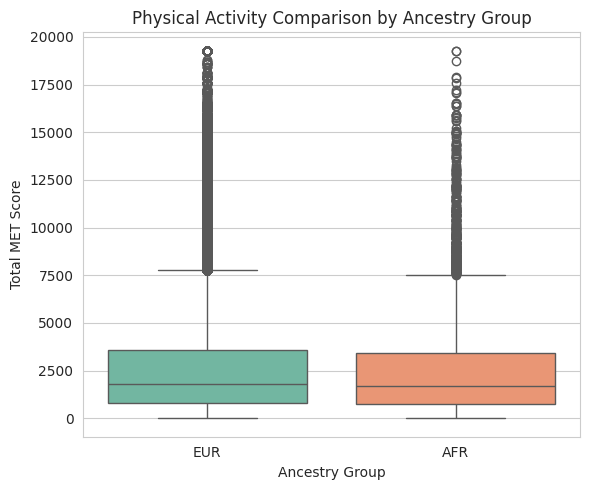

In [79]:
plt.rcParams.update({'font.family': 'sans-serif'})

plt.figure(figsize=(6, 5))
sns.boxplot(data=df_3, x="pop", y="p22040_i0", palette="Set2", hue="pop")
plt.title("Physical Activity Comparison by Ancestry Group")
plt.xlabel("Ancestry Group")
plt.ylabel("Total MET Score")
plt.tight_layout()
plt.show()

### 9. Basal metabolic rate
Basal metabolic rate (BMR) is the rate at which the body expends energy (calories) at rest to maintain basic life-sustaining functions. BMR is the amount of energy utilized by the body in physical and psychological resting rate, after a night sleep, awake without any previous physical activity post meal (10 h after last meal) & neutral environment.

The UK Biobank used the Tanita BC418MA to measure the bioelectrical impedance analysis (BIA) to estimate BMR. This method involves passing a small electrical current through the body to estimate body composition, which is then used to calculate BMR. 

In people with type 2 diabetes mellitus (T2DM) there is an increase in BMR which is said to be associated with the level of glycaemic control (Sampath Kumar et al., 2019)
https://www.sciencedirect.com/science/article/pii/S1871402118304053?via%3Dihub.

In the UK biobank, it is Body composition estimation by impedance measurement using field `23105`.

In [84]:
df_3['p23105_i0'].value_counts(dropna=False)

p23105_i0
NaN        7363
5393.0      722
5506.0      704
5544.0      704
5431.0      699
           ... 
11799.0       1
13104.0       1
12426.0       1
15506.0       1
12841.0       1
Name: count, Length: 2150, dtype: int64

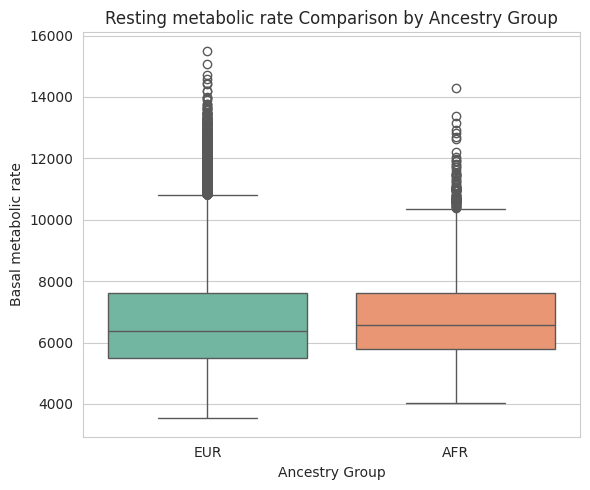

In [80]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_3, x="pop", y="p23105_i0", palette="Set2", hue="pop")
plt.title("Resting metabolic rate Comparison by Ancestry Group")
plt.xlabel("Ancestry Group")
plt.ylabel("Basal metabolic rate")
plt.tight_layout()
plt.show()

### 10. Alcohol intake frequency
<code> OrderedDict([('1', 'Daily or almost daily'),
             ('2', 'Three or four times a week'),
             ('3', 'Once or twice a week'),
             ('4', 'One to three times a month'),
             ('5', 'Special occasions only'),
             ('6', 'Never'),
             ('-3', 'Prefer not to answer')])
    </code>

In [87]:
# Assign a `nan` value to values labelled '-3'
df_3['p1558_i0'] = df_3['p1558_i0'].replace(-3, np.nan)

In [88]:
df_3['p1558_i0'].value_counts(dropna=False)

p1558_i0
3.0    109799
2.0     99373
1.0     87110
4.0     46504
5.0     45656
6.0     28714
NaN       311
Name: count, dtype: int64

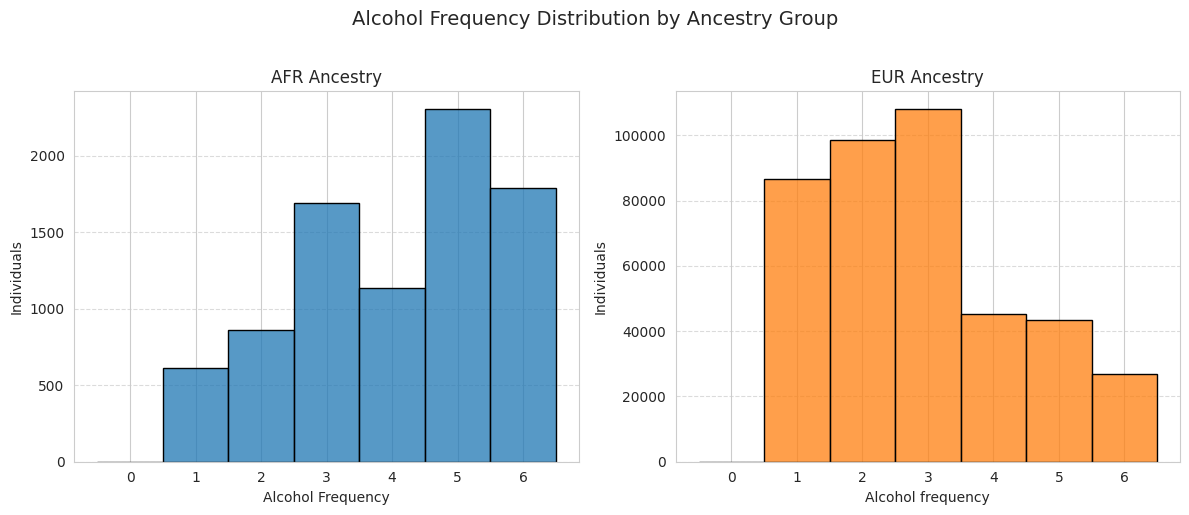

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset data
afr_data = df_3[df_3["pop"] == "AFR"]
eur_data = df_3[df_3["pop"] == "EUR"]

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# AFR Histogram
bins = np.arange(-0.5, 7.5, 1)

sns.histplot(
    data=afr_data,
    x="p1558_i0",
    bins=bins,
    ax=axes[0],
    color="#1f77b4",
    edgecolor="black"
)
axes[0].set_title("AFR Ancestry")
axes[0].set_xlabel("Alcohol Frequency")
axes[0].set_ylabel("Individuals")
axes[0].set_xticks(range(0, 10))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# EUR Histogram
sns.histplot(
    data=eur_data,
    x="p1558_i0",
    bins=bins,
    ax=axes[1],
    color="#ff7f0e",
    edgecolor="black"
)
axes[1].set_title("EUR Ancestry")
axes[1].set_xlabel("Alcohol frequency")
axes[1].set_ylabel("Individuals")
axes[1].set_xticks(range(0, 7))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Alcohol Frequency Distribution by Ancestry Group", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 11. Average total household income before tax

In [95]:
## assign nan to "-3": "Do not Know" and "-1" : prefer not to say

import numpy as np
df_3['p738_i0'] = df_3['p738_i0'].replace([-3, -1], np.nan)

In [96]:
df_3['p738_i0'].value_counts(dropna=False)

p738_i0
3.0    94250
2.0    92746
1.0    81129
4.0    72042
NaN    58981
5.0    18319
Name: count, dtype: int64

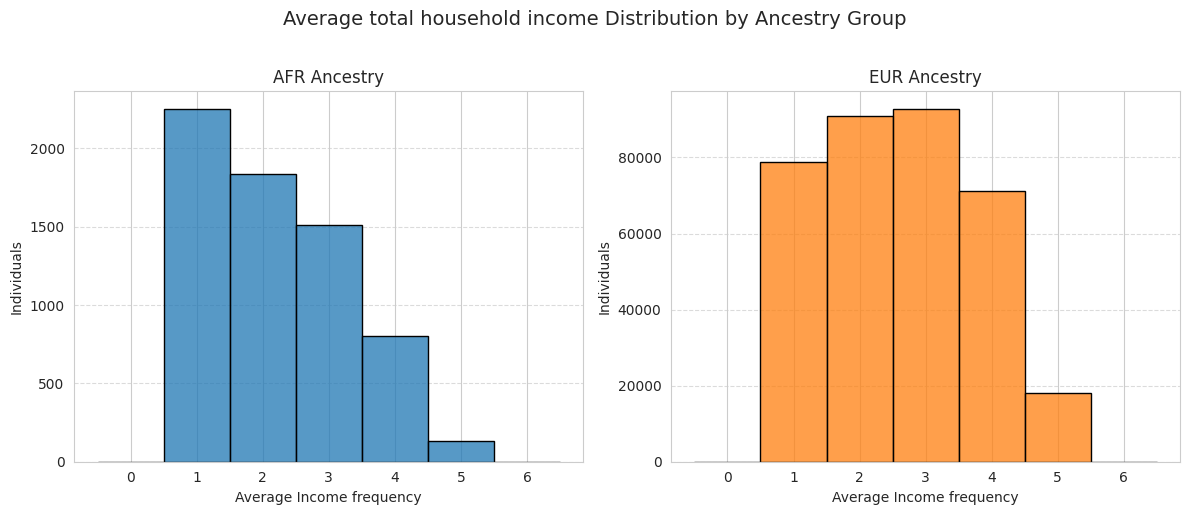

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset data
afr_data = df_3[df_3["pop"] == "AFR"]
eur_data = df_3[df_3["pop"] == "EUR"]

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# AFR Histogram
bins = np.arange(-0.5, 7.5, 1)

sns.histplot(
    data=afr_data,
    x="p738_i0",
    bins=bins,
    ax=axes[0],
    color="#1f77b4",
    edgecolor="black"
)
axes[0].set_title("AFR Ancestry")
axes[0].set_xlabel("Average Income frequency")
axes[0].set_ylabel("Individuals")
axes[0].set_xticks(range(0, 10))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# EUR Histogram
sns.histplot(
    data=eur_data,
    x="p738_i0",
    bins=bins,
    ax=axes[1],
    color="#ff7f0e",
    edgecolor="black"
)
axes[1].set_title("EUR Ancestry")
axes[1].set_xlabel("Average Income frequency")
axes[1].set_ylabel("Individuals")
axes[1].set_xticks(range(0, 7))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Average total household income Distribution by Ancestry Group", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 12. BMI

In [98]:
df_3["p21001_i0"].describe()

count    416052.000000
mean         27.454036
std           4.778545
min          12.121200
25%          24.175100
50%          26.769800
75%          29.920550
max          74.683700
Name: p21001_i0, dtype: float64

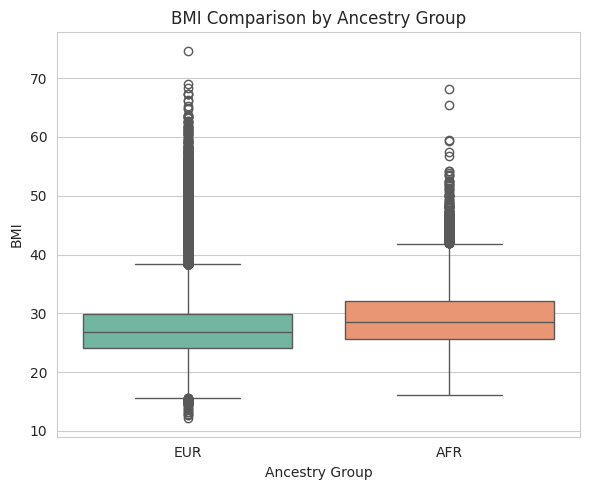

In [99]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_3, x="pop", y="p21001_i0", palette="Set2", hue="pop")
plt.title("BMI Comparison by Ancestry Group")
plt.xlabel("Ancestry Group")
plt.ylabel("BMI")
plt.tight_layout()
plt.show()

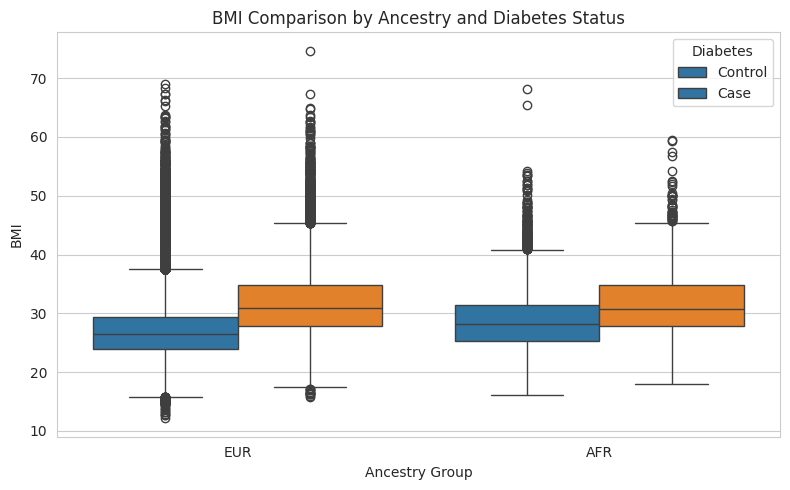

In [100]:
plt.figure(figsize=(8, 5))
custom_palette = {0: "#1f77b4", 1: "#ff7f0e"}
sns.boxplot(
    data=df_3,
    x="pop",
    y="p21001_i0",  # BMI
    hue="p41270",  # Case-control groups
    palette=custom_palette
)
plt.title("BMI Comparison by Ancestry and Diabetes Status")
plt.xlabel("Ancestry Group")
plt.ylabel("BMI")
plt.legend(title="Diabetes", labels=["Control", "Case"])
plt.tight_layout()
plt.show()


In [101]:

## Mapping the dataset with the right col_names

In [105]:
df_3 = df_3.rename(columns={'eid':'IID', "p31": "sex", "p20160_i0":"ever_smoked","p21001_i0":"bmi", "p41270":"t2d_cc", 
                                                 "p26285":"prs_t2d", "p23105_i0":"bmr", "p22040_i0":"total_met", 
                                                  "p738_i0": "av_income", "p1160_i0": "sleep_dur", "p21002_i0":"weight",
                                                  "p50_i0":"height","p22189":"townsend", "p1558_i0":"alcohol_intake", "p21022":"age"})

In [106]:
df_3.head()

,IID,age,sex,ever_smoked,p20116_i0,sleep_dur,av_income,bmi,bmr,total_met,...,p20524,p20523,p20521,t2d_cc,prs_t2d,pop,whr,cmcs,ipvs,diet_score
0,1000011,46,1,0.0,0.0,7.0,1.0,39.0082,11795.0,1000.0,...,NaN,NaN,NaN,1,-0.38477,EUR,1.065041,NaN,NaN,4.0
2,1001038,61,1,1.0,2.0,8.0,3.0,24.7128,7477.0,1390.5,...,NaN,NaN,NaN,1,1.73488,EUR,0.871287,NaN,NaN,NaN
4,1002955,65,0,1.0,1.0,6.0,2.0,30.5594,6017.0,996.0,...,NaN,NaN,NaN,1,1.49729,EUR,0.911504,NaN,NaN,6.0
5,1003669,69,1,1.0,2.0,7.0,1.0,22.8984,5832.0,693.0,...,0.0,0.0,0.0,1,-0.52105,EUR,0.958333,2.0,0.0,2.0
6,1003937,65,1,1.0,1.0,6.0,2.0,27.3868,7699.0,3625.5,...,0.0,0.0,0.0,1,0.03604,EUR,0.940594,0.0,0.0,4.0


In [107]:
df_3.columns

Index(['IID', 'age', 'sex', 'ever_smoked', 'p20116_i0', 'sleep_dur',
       'av_income', 'bmi', 'bmr', 'total_met', 'p48_i0', 'p49_i0', 'weight',
       'height', 'alcohol_intake', 'townsend', 'p1349_i0', 'p1369_i0',
       'p1329_i0', 'p1339_i0', 'p1418_i0', 'p1428_i0', 'p1448_i0', 'p1478_i0',
       'p1528_i0', 'p1309_i0', 'p1289_i0', 'p20490', 'p20488', 'p20487',
       'p20531', 'p20524', 'p20523', 'p20521', 't2d_cc', 'prs_t2d', 'pop',
       'whr', 'cmcs', 'ipvs', 'diet_score'],
      dtype='object')

In [108]:
df_gxe = df_3[[
    'IID',         # Participant ID
    'age',         # Age
    'sex',         # Sex
    'pop',         # Population group (e.g., AFR, EUR)
    'ever_smoked', # Smoking history
    'sleep_dur',      # Sleep duration
    'alcohol_intake', # alcohol intake
    'av_income',      # Average income
    'bmi',            # Body mass index
    'bmr',            # Basal metabolic rate
    'total_met',      # Total MET minutes
    'weight',         # Weight
    'height',         # Height
    'whr',            # waist-hip ratio
    'townsend',       # Area-based deprivation
    'prs_t2d',        # Polygenic Risk Score for T2D
    'cmcs',           # Cardiometabolic comorbidity score
    'ipvs',           # Individual polyenvironmental score
    'diet_score',     # Diet quality score
    't2d_cc'         # Type 2 Diabetes status (0/1)
]].copy()


In [109]:
df_gxe.shape

(417467, 20)

In [110]:
df_gxe['sex'].value_counts()

sex
0    225995
1    191472
Name: count, dtype: int64

In [111]:
df_gxe.isna().sum()

IID                    0
age                    0
sex                    0
pop                    0
ever_smoked         1394
sleep_dur           2428
alcohol_intake       311
av_income          58981
bmi                 1415
bmr                 7363
total_met          93643
weight              1254
height               973
whr                  850
townsend             498
prs_t2d             1312
cmcs              285925
ipvs              286229
diet_score         67449
t2d_cc                 0
dtype: int64

In [112]:
df_gxe_clean = df_gxe.dropna()

In [113]:
df_gxe_clean.shape

(84239, 20)

In [114]:
df_gxe

,IID,age,sex,pop,ever_smoked,sleep_dur,alcohol_intake,av_income,bmi,bmr,total_met,weight,height,whr,townsend,prs_t2d,cmcs,ipvs,diet_score,t2d_cc
0,1000011,46,1,EUR,0.0,7.0,6.0,1.0,39.0082,11795.0,1000.0,143.8,192.0,1.065041,-2.73,-0.38477,NaN,NaN,4.0,1
2,1001038,61,1,EUR,1.0,8.0,3.0,3.0,24.7128,7477.0,1390.5,78.3,178.0,0.871287,-2.58,1.73488,NaN,NaN,NaN,1
4,1002955,65,0,EUR,1.0,6.0,6.0,2.0,30.5594,6017.0,996.0,80.2,162.0,0.911504,5.80,1.49729,NaN,NaN,6.0,1
5,1003669,69,1,EUR,1.0,7.0,6.0,1.0,22.8984,5832.0,693.0,65.4,169.0,0.958333,-3.12,-0.52105,2.0,0.0,2.0,1
6,1003937,65,1,EUR,1.0,6.0,5.0,2.0,27.3868,7699.0,3625.5,85.8,177.0,0.940594,-0.38,0.03604,0.0,0.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502123,1055111,54,0,EUR,1.0,6.0,5.0,3.0,37.5381,6489.0,1824.0,94.9,159.0,0.808333,-4.39,-1.45339,NaN,NaN,5.0,0
502124,2662839,41,1,EUR,0.0,8.0,3.0,4.0,21.8007,6464.0,3124.0,60.8,167.0,0.838710,-2.51,-0.05618,0.0,0.0,4.0,0
502125,3822589,64,1,EUR,1.0,7.0,2.0,2.0,36.4780,9979.0,1380.0,123.5,184.0,1.083333,-1.23,-0.85196,NaN,NaN,5.0,0
502126,4396029,45,0,EUR,0.0,8.0,4.0,5.0,25.0995,5837.0,1262.0,70.0,167.0,0.786408,-2.09,0.11600,NaN,NaN,6.0,0


In [117]:
df_gxe_clean.groupby(['pop', 't2d_cc']).size().unstack(fill_value=0)

t2d_cc,0,1
pop,,
AFR,650,57
EUR,79252,4280


In [118]:
df_gxe.groupby(['pop', 't2d_cc']).size().unstack(fill_value=0)

t2d_cc,0,1
pop,,
AFR,6940,1478
EUR,375507,33542


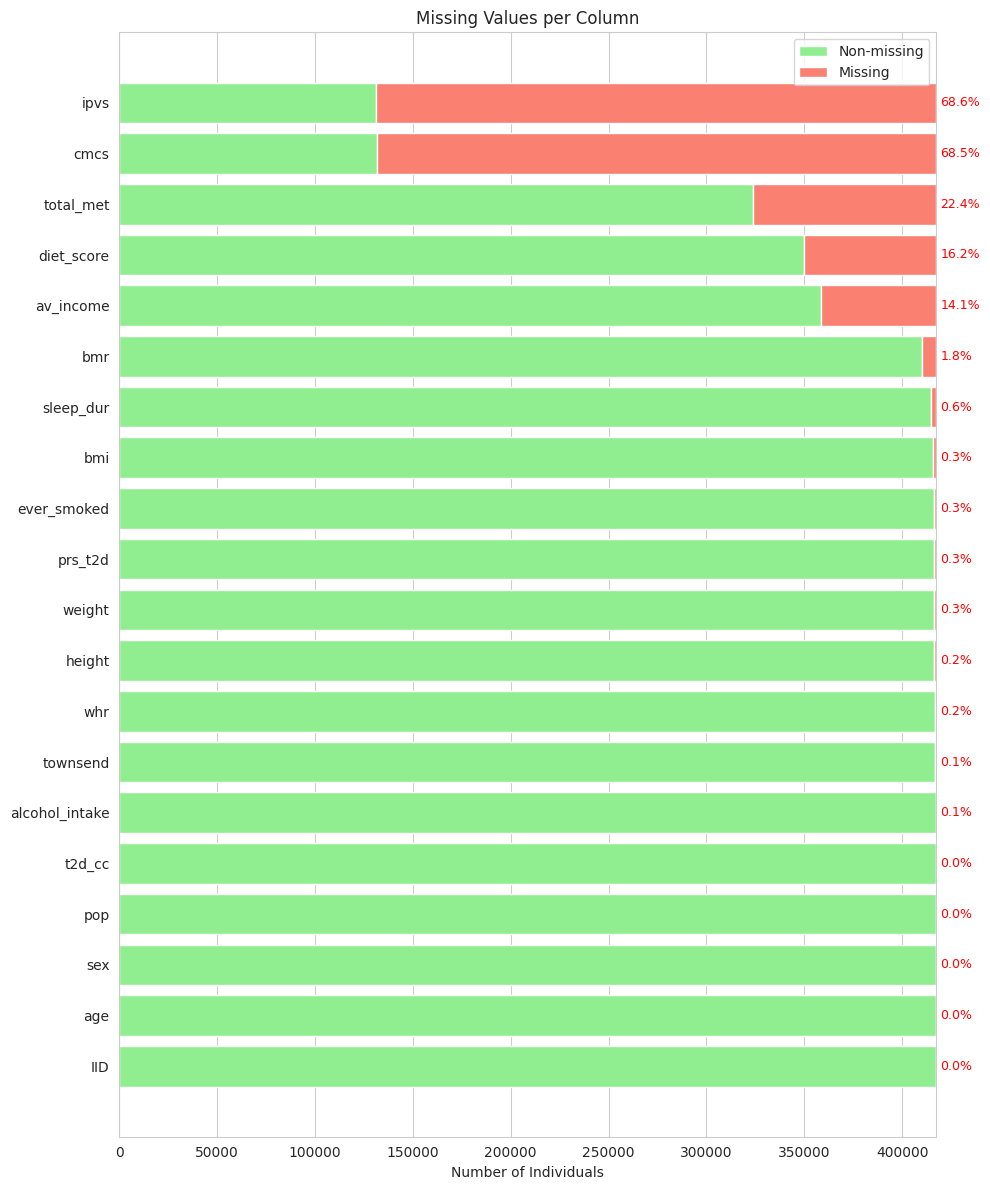

In [120]:
## visualising the missing values in the dataset
import matplotlib.pyplot as plt

# Total number of rows
n_total = len(df_gxe)

# Get counts of missing and non-missing for each column
missing = df_gxe.isnull().sum()
non_missing = n_total - missing

# Combine into a DataFrame
missing_df = pd.DataFrame({
    'Missing': missing,
    'Non-missing': non_missing
})

# Sort by % missing
missing_df['% Missing'] = (missing_df['Missing'] / n_total) * 100
missing_df = missing_df.sort_values('% Missing', ascending=True)

# Plot
plt.figure(figsize=(10, 12))
bars_nonmissing = plt.barh(missing_df.index, missing_df['Non-missing'], color='lightgreen', label='Non-missing')
bars_missing = plt.barh(missing_df.index, missing_df['Missing'], left=missing_df['Non-missing'], color='salmon', label='Missing')

# Add missing % text labels to the right of each bar
for i, (total, missing_val, percent) in enumerate(zip(missing_df['Non-missing'] + missing_df['Missing'],
                                                       missing_df['Missing'],
                                                       missing_df['% Missing'])):
    plt.text(total + n_total*0.005,  # small space after the end of the bar
             i, 
             f"{percent:.1f}%", 
             va='center', 
             fontsize=9, 
             color='red')

plt.xlabel("Number of Individuals")
plt.title("Missing Values per Column")
plt.legend()
plt.tight_layout()
plt.show()


In [121]:
cat_col = ['sex','pop','ever_smoked', 'alcohol_intake', 'av_income', 'cmcs', 'ipvs', 'diet_score', 'sleep_dur']
num_col = ['age', 'bmi', 'bmr', 'total_met','townsend', 'whr', 'prs_t2d']

### Correlation of the numerical variables with T2D

In [135]:
correlations = df_gxe_clean[num_col].corr()['bmi'].sort_values(ascending=False)

In [136]:
print(df_gxe.columns)

Index(['IID', 'age', 'sex', 'pop', 'ever_smoked', 'sleep_dur',
       'alcohol_intake', 'av_income', 'bmi', 'bmr', 'total_met', 'weight',
       'height', 'whr', 'townsend', 'prs_t2d', 'cmcs', 'ipvs', 'diet_score',
       't2d_cc'],
      dtype='object')


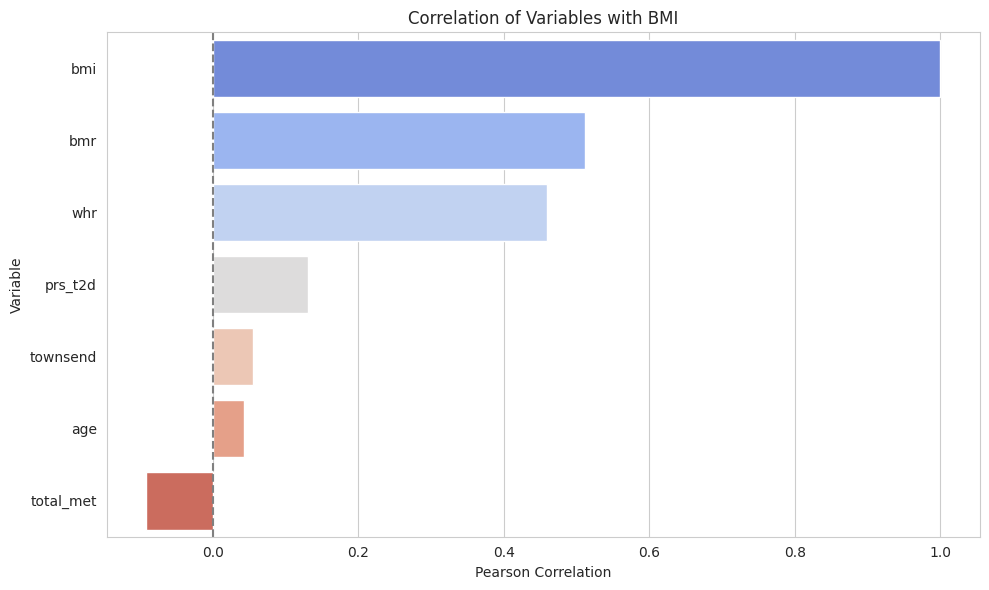

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm", hue=correlations.index)
plt.title("Correlation of Variables with BMI")
plt.xlabel("Pearson Correlation")
plt.ylabel("Variable")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


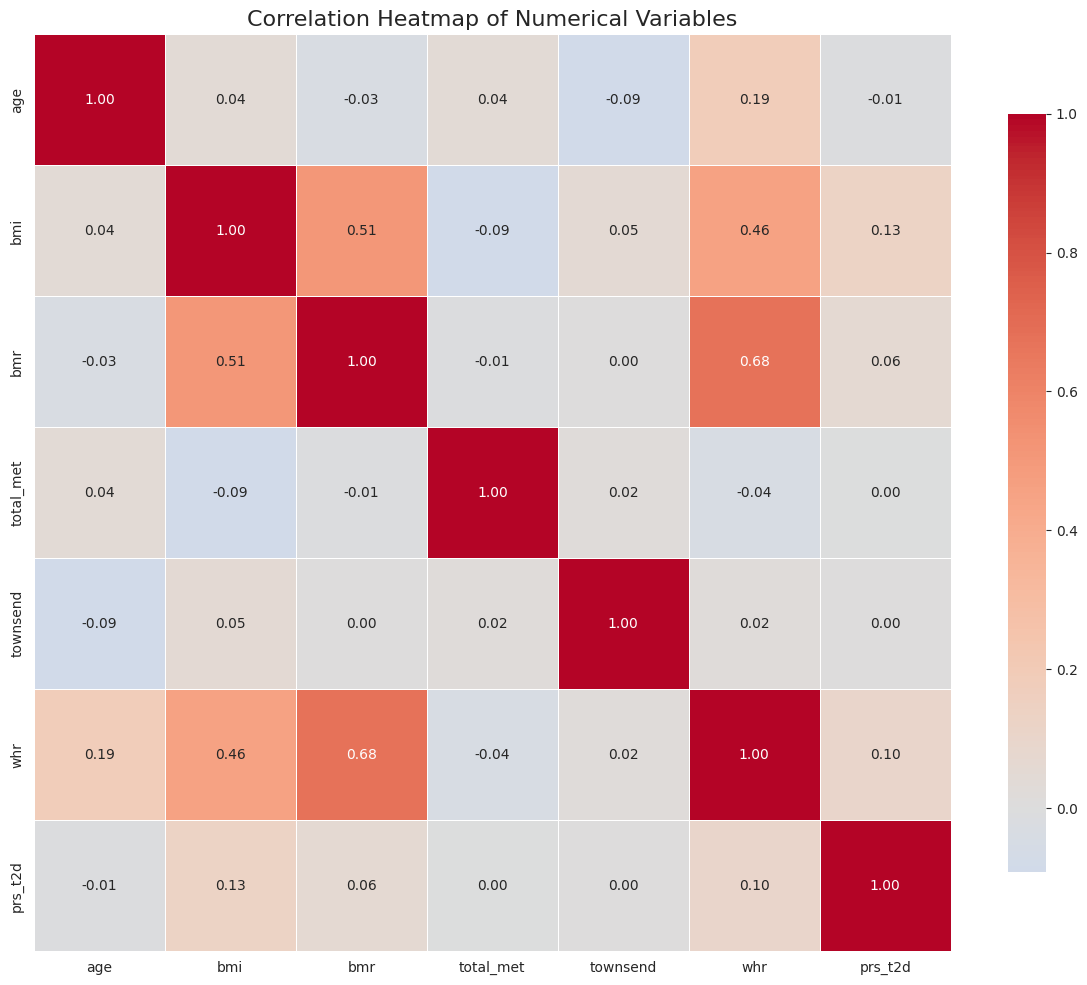

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute full correlation matrix for numeric columns
corr_matrix = df_gxe_clean[num_col].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,          # Show correlation values
    fmt=".2f",           # Format for correlation numbers
    cmap="coolwarm",     # Color map
    center=0,            # Center color gradient at 0
    square=True,         # Square cells
    linewidths=0.5,      # Line width between cells
    cbar_kws={"shrink": 0.8}  # Color bar size
)

plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.tight_layout()
plt.show()


## Dealing with missing values
Xgboost automatically handles missing values by passing the param missing=np.nan
https://youtu.be/cVqDguNWh4M

In [132]:
# Save to TSV
df_gxe_clean.to_csv("dataset_no_nan.csv", sep="\t", index=False)

In [133]:
# Save to TSV
df_gxe.to_csv("dataset_with_nan.csv", sep="\t", index=False)

## Comparing the predictive power of PRS in "EUR" and "AFR" ancestry groups

In [17]:
import pandas as pd
df_gxe = pd.read_csv("dataset_with_nan.csv", sep="\t")

In [18]:
df_gxe.groupby(['pop', 't2d_cc']).size().unstack(fill_value=0)

t2d_cc,0,1
pop,,
AFR,6940,1478
EUR,375507,33542


In [19]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

# Split data
afr_df = df_gxe[df_gxe['pop'] == 'AFR']
eur_df = df_gxe[df_gxe['pop'] == 'EUR']

def evaluate_prs(df, label=""):
    # Drop missing values in PRS or outcome
    df = df[['t2d_cc', 'prs_t2d']].dropna()

    # Add constant for intercept
    X = sm.add_constant(df['prs_t2d'])
    y = df['t2d_cc']

    model = sm.Logit(y, X).fit(disp=0)
    print(f"\n{label} Population:")
    print(model.summary())

    # AUC
    y_pred_prob = model.predict(X)
    auc = roc_auc_score(y, y_pred_prob)
    print(f"AUC: {auc:.3f}")
    return auc, model

# Evaluate
auc_afr, model_afr = evaluate_prs(afr_df, label="AFR")
auc_eur, model_eur = evaluate_prs(eur_df, label="EUR")



AFR Population:
                           Logit Regression Results                           
Dep. Variable:                 t2d_cc   No. Observations:                 8406
Model:                          Logit   Df Residuals:                     8404
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Dec 2025   Pseudo R-squ.:                 0.01925
Time:                        16:04:43   Log-Likelihood:                -3826.0
converged:                       True   LL-Null:                       -3901.1
Covariance Type:            nonrobust   LLR p-value:                 1.598e-34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6034      0.030    -53.524      0.000      -1.662      -1.545
prs_t2d        0.3259      0.027     12.116      0.000       0.273       0.379
AUC: 0.600

EUR Population:
       

In [20]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
def nagelkerke_r2(model):
    """
    Computes Nagelkerke R² for a fitted statsmodels Logit model.
    
    Parameters:
    -----------
    model : statsmodels.discrete.discrete_model.BinaryResultsWrapper
        A fitted logistic regression model (from sm.Logit().fit()).

    Returns:
    --------
    dict
        A dictionary with number of observations and Nagelkerke R².
    """
    n = model.nobs
    ll_model = model.llf
    ll_null = model.llnull
    r2 = (1 - np.exp((ll_null - ll_model) * 2 / n)) / (1 - np.exp(ll_null * 2 / n))
    
    return {"N": int(n), "R2": r2}


In [22]:
import statsmodels.api as sm
import numpy as np

afr_df = afr_df[['t2d_cc', 'prs_t2d']].dropna()
# Fit model
model_afr = sm.Logit(afr_df['t2d_cc'], sm.add_constant(afr_df['prs_t2d'])).fit()

# Get Nagelkerke R²
result_afr = nagelkerke_r2(model_afr)
print(f"Nagelkerke R²: {result_afr['R2']:.4f}")


Optimization terminated successfully.
         Current function value: 0.455154
         Iterations 6
Nagelkerke R²: 0.0293


In [23]:
import statsmodels.api as sm
import numpy as np

eur_df = eur_df[['t2d_cc', 'prs_t2d']].dropna()
# Fit model
model_eur = sm.Logit(eur_df['t2d_cc'], sm.add_constant(eur_df['prs_t2d'])).fit()

# Get Nagelkerke R²
result_eur = nagelkerke_r2(model_eur)
print(f"Nagelkerke R²: {result_eur['R2']:.4f}")


Optimization terminated successfully.
         Current function value: 0.266146
         Iterations 7
Nagelkerke R²: 0.0783


<Detail><strong>
Using Nagelkerke R2 as a psuedo R2 measure of the model performance shows that the genetic variation in individuals of African Ancestry explains 2.93% of type 2 diabetes while the percentage is higher for indiviuals of European Ancestry at 7.83%
</strong></Detail>

#### Visualising the predictive performance of both PRS

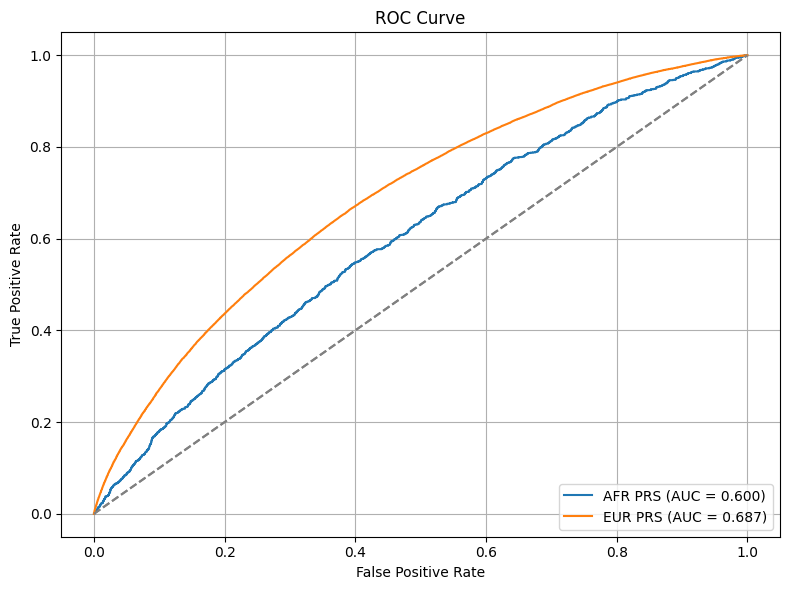

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_score, label='Model'):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)

# Example for AFR and EUR
roc_pic = plt.figure(figsize=(8, 6))

plot_roc_curve(afr_df['t2d_cc'], afr_df['prs_t2d'], label="AFR PRS")
plot_roc_curve(eur_df['t2d_cc'], eur_df['prs_t2d'], label="EUR PRS")

plt.tight_layout()
plt.show()


The closer the AUC gets to 1 the better the predictive power.

Its is evident that PRS in individuals of EUR ancestry is more predictive than that in individuals of African ancestry 

In [25]:
roc_pic.savefig("eur_afr_roc_curves")

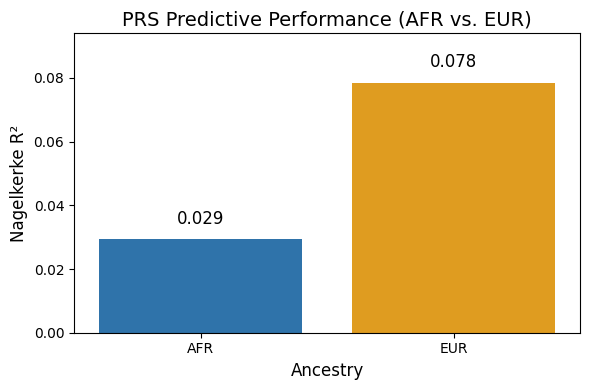

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_r2 = pd.DataFrame({
     'Population': ['AFR', 'EUR'],
     'Nagelkerke R²': [result_afr['R2'], result_eur['R2']]
 })
    
 # Plot
nagelkerke_plot = plt.figure(figsize=(6, 4))
sns.barplot(x='Population', y='Nagelkerke R²', data=df_r2, hue = 'Population', legend=False, palette={'AFR': '#1b75be', 'EUR': 'orange'})
    
# # Customize plot
plt.title('PRS Predictive Performance (AFR vs. EUR)', fontsize=14)
plt.ylabel('Nagelkerke R²', fontsize=12)
plt.xlabel('Ancestry', fontsize=12)
plt.ylim(0, max(result_afr['R2'], result_eur['R2']) * 1.2)  # Auto-adjust y-axis
    
# # Add value labels on top of bars
for index, row in df_r2.iterrows():
    plt.text(index, row['Nagelkerke R²'] + 0.005, f"{row['Nagelkerke R²']:.3f}", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
nagelkerke_plot.savefig("Nagelkerke_bar.png")

In [27]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Prepare data
# afr_df['Ancestry'] = 'AFR'
# eur_df['Ancestry'] = 'EUR'
# combined_df = pd.concat([afr_df, eur_df])
# combined_df['Status'] = combined_df['t2d_cc'].map({0: 'Control', 1: 'Case'})

# # Create plot
# plt.figure(figsize=(10, 6))
# ax = sns.boxplot(
#     x='Ancestry',
#     y='prs_t2d',
#     hue='Status',
#     data=combined_df,
#     palette={'Control': '#56B4E9', 'Case': '#fc036f'},
#     width=0.6,
#     dodge=True,
#     gap=0.1
# )

# # Calculate positions manually
# n_groups = len(combined_df['Ancestry'].unique())  # Number of ancestry groups
# n_hues = len(combined_df['Status'].unique())     # Number of status categories
# total_width = 0.8
# bar_width = total_width/n_hues

# # Calculate x positions for each box
# x_positions = []
# for i in range(n_groups):
#     for j in range(n_hues):
#         x_positions.append(i - total_width/2 + bar_width/2 + j*bar_width)

# # Add sample size labels
# # for i, (ancestry, status) in enumerate([(a, s) for a in ['AFR', 'EUR'] for s in ['Control', 'Case']]):
# #     subset = combined_df[(combined_df['Ancestry'] == ancestry) & (combined_df['Status'] == status)]
# #     if len(subset) > 0:
# #         ax.text(x_positions[i],
# #                 subset['prs_t2d'].median(),
# #                 f'N={len(subset)}' if status == 'Control' else f'N={len(subset)}',
# #                 ha='center',
# #                 va='center',
# #                 fontsize=10,
# #                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))

# # Final styling
# plt.title('PRS Distribution by Ancestry and Case/Control Status', fontsize=14, pad=20)
# plt.ylabel('Polygenic Risk Score (PRS)', fontsize=12)
# plt.xlabel('Ancestry Group', fontsize=12)
# plt.legend(title='Diabetes Status', bbox_to_anchor=(1.05, 1), loc='upper left')
# sns.despine()
# plt.tight_layout()
# plt.show()

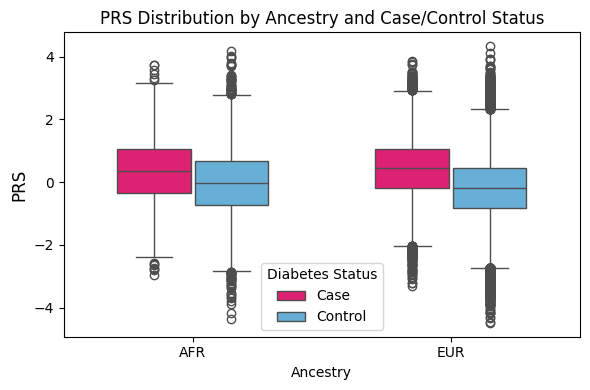

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data - add ancestry labels and combine
afr_df['Ancestry'] = 'AFR'
eur_df['Ancestry'] = 'EUR'
combined_df = pd.concat([afr_df, eur_df])

# Convert case/control to categorical for better labeling
combined_df['Status'] = combined_df['t2d_cc'].map({0: 'Control', 1: 'Case'})

# Create plot
prs_distribution = plt.figure(figsize=(6, 4))
ax=sns.boxplot(
    x='Ancestry',
    y='prs_t2d',
    hue='Status',
    data=combined_df,
    palette={'Control': '#56B4E9', 'Case': '#fc036f'},  # Blue for controls, orange for cases
    #showfliers=False,  # Hide outliers for cleaner plot
    width=0.6,
    dodge=True,  # Adds separation between case/control boxes
    gap=0.05 # Adds space between groups
)

# # Add plot decorations
plt.title('PRS Distribution by Ancestry and Case/Control Status', fontsize=12)
plt.ylabel('PRS', fontsize=12)
#plt.xlabel('Ancestry Group', fontsize=12)
plt.legend(title='Diabetes Status')

plt.tight_layout()
plt.show()


In [26]:
prs_distribution.savefig("prs_disribution.png")

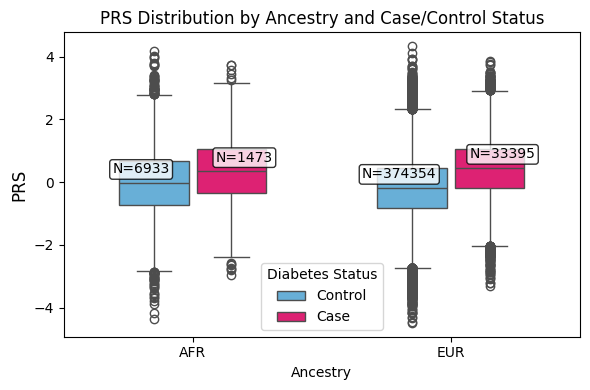

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
afr_df['Ancestry'] = 'AFR'
eur_df['Ancestry'] = 'EUR'
combined_df = pd.concat([afr_df, eur_df])
combined_df['Status'] = combined_df['t2d_cc'].map({0: 'Control', 1: 'Case'})

# Explicitly set the order of categories
status_order = ['Control', 'Case']

# Create plot
prs_dist = plt.figure(figsize=(6, 4))
ax = sns.boxplot(
    x='Ancestry',
    y='prs_t2d',
    hue='Status',
    data=combined_df,
    hue_order=status_order,  # Ensure consistent order
    palette={'Control': '#56B4E9', 'Case': '#fc036f'},
    width=0.6,
    dodge=True,
    gap=0.1
)

# Calculate positions manually - now respecting the hue_order
n_groups = len(combined_df['Ancestry'].unique())  # Number of ancestry groups
n_hues = len(status_order)                       # Number of status categories
total_width = 0.8
bar_width = total_width/n_hues

# Calculate x positions for each box
x_positions = []
for i in range(n_groups):
    for j in range(n_hues):
        x_positions.append(i - total_width/2 + bar_width/2 + j*bar_width)
label_offset = 0.05 * (combined_df['prs_t2d'].max() - combined_df['prs_t2d'].min())  # 5% of range

for i, (ancestry, status) in enumerate([(a, s) for a in ['AFR', 'EUR'] for s in status_order]):
    subset = combined_df[(combined_df['Ancestry'] == ancestry) & (combined_df['Status'] == status)]
    if len(subset) > 0:
        ax.text(x_positions[i],
                subset['prs_t2d'].median() + label_offset,  # Added offset here
                f'N={len(subset)}',
                ha='center',
                va='center',
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))

plt.title('PRS Distribution by Ancestry and Case/Control Status', fontsize=12)
plt.ylabel('PRS', fontsize=12)
#plt.xlabel('Ancestry Group', fontsize=12)
plt.legend(title='Diabetes Status')

plt.tight_layout()
plt.show()


In [12]:
prs_dist.savefig("prs_disribution_n.png")

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd


In [6]:
import os
os.chdir("../proj_GxE/")
os.getcwd()

'/users/rmatovu/proj_GxE'

In [29]:
afr_best_prs = pd.read_csv("best_afr_prs_dataset.csv")
afr_best_prs.head()

,FID,IID,age,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,t2d_cc,best_prs_raw,best_prs_std
0,1000951,1000951,48,1,381.818,71.7221,-5.50858,6.42666,-0.771532,-3.859040,0.701624,-0.193217,2.143880,1.648180,0,-1.411,-1.397362
1,1001707,1001707,44,1,411.019,76.6984,-6.93557,7.28527,-0.710487,-0.683901,-2.043240,0.995539,-0.760038,3.070010,0,-0.503,-0.524896
2,1001801,1001801,67,0,384.252,71.4446,-9.19076,3.95649,-2.863300,-3.087010,-3.882210,-2.401020,-2.349530,7.501970,1,0.269,0.216891
3,1001846,1001846,54,1,402.686,77.4245,-2.94899,6.74229,-1.726930,-1.567780,-0.936775,-1.375170,-0.571782,4.453360,0,1.002,0.921205
4,1002237,1002237,51,0,150.270,29.6377,-3.90076,5.05590,1.205160,2.490350,-0.837907,0.967479,-1.056030,0.111773,0,0.005,-0.036777


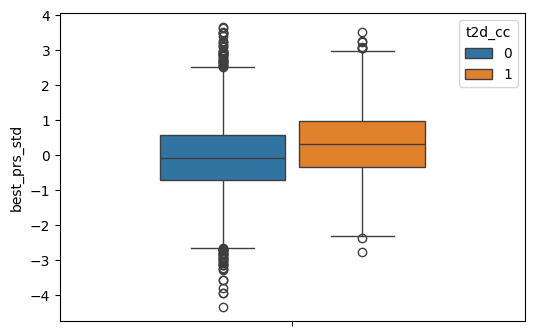

In [28]:

# Create plot
prs_best_dist = plt.figure(figsize=(6, 4))
ax = sns.boxplot(
    
    y='best_prs_std',
    hue='t2d_cc',
    data=afr_best_prs,
    #hue_order=status_order,  # Ensure consistent order
    #palette={'Control': '#56B4E9', 'Case': '#fc036f'},
    width=0.6,
    dodge=True,
    gap=0.1
)

In [38]:
### 1. Fit logistic regression for NEW AFR PRS ###
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Load new AFR PRS dataset
afr_best_prs = pd.read_csv("best_afr_prs_dataset.csv")

# Define predictors
X_newAFR = afr_best_prs[['best_prs_std']]
X_newAFR = sm.add_constant(X_newAFR)

y_newAFR = afr_best_prs['t2d_cc']

# Fit model
model_newAFR = sm.Logit(y_newAFR, X_newAFR).fit(disp=0)

# Compute Nagelkerke R²
result_newAFR = nagelkerke_r2(model_newAFR)

print("AFR_SUZUKI R²:", result_newAFR['R2'])


AFR_SUZUKI R²: 0.039634625458530456


In [39]:
df_r2_compare = pd.DataFrame({
    'PRS': ['AFR', 'EUR', 'AFR_SUZUKI'],
    'Nagelkerke R²': [
        result_afr['R2'],     # OLD AFR
        result_eur['R2'],     # OLD EUR
        result_newAFR['R2']   # NEW AFR
    ]
})


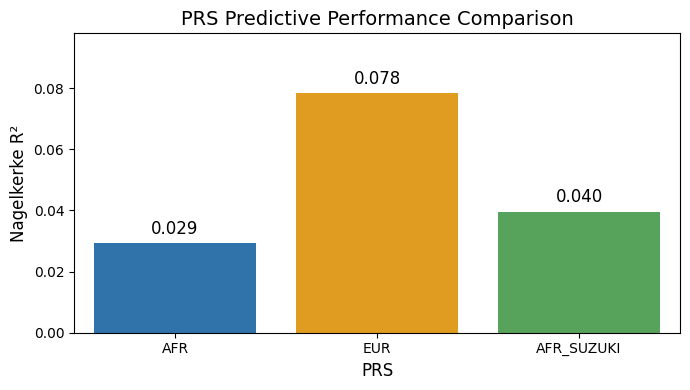

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom colors
palette = {
    'AFR': '#1b75be',
    'EUR': 'orange',
    'AFR_SUZUKI': '#4caf50'   # green for new AFR PRS
}

prs_suzuki = plt.figure(figsize=(7, 4))
sns.barplot(x='PRS', y='Nagelkerke R²', data=df_r2_compare, hue = 'PRS', palette=palette)

plt.title('PRS Predictive Performance Comparison', fontsize=14)
plt.xlabel('PRS', fontsize=12)
plt.ylabel('Nagelkerke R²', fontsize=12)
plt.ylim(0, max(df_r2_compare['Nagelkerke R²']) * 1.25)

# Add numeric labels
for i, row in df_r2_compare.iterrows():
    plt.text(i, row['Nagelkerke R²'] + 0.003,
             f"{row['Nagelkerke R²']:.3f}",
             ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [44]:
prs_suzuki.savefig('PRS_prediction.png')

In [45]:
afr_best_prs.head()

,FID,IID,age,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,t2d_cc,best_prs_raw,best_prs_std
0,1000951,1000951,48,1,381.818,71.7221,-5.50858,6.42666,-0.771532,-3.859040,0.701624,-0.193217,2.143880,1.648180,0,-1.411,-1.397362
1,1001707,1001707,44,1,411.019,76.6984,-6.93557,7.28527,-0.710487,-0.683901,-2.043240,0.995539,-0.760038,3.070010,0,-0.503,-0.524896
2,1001801,1001801,67,0,384.252,71.4446,-9.19076,3.95649,-2.863300,-3.087010,-3.882210,-2.401020,-2.349530,7.501970,1,0.269,0.216891
3,1001846,1001846,54,1,402.686,77.4245,-2.94899,6.74229,-1.726930,-1.567780,-0.936775,-1.375170,-0.571782,4.453360,0,1.002,0.921205
4,1002237,1002237,51,0,150.270,29.6377,-3.90076,5.05590,1.205160,2.490350,-0.837907,0.967479,-1.056030,0.111773,0,0.005,-0.036777


In [46]:
df_gxe.head()

,IID,age,sex,pop,ever_smoked,sleep_dur,alcohol_intake,av_income,bmi,bmr,total_met,weight,height,whr,townsend,prs_t2d,cmcs,ipvs,diet_score,t2d_cc
0,1000011,46,1,EUR,0.0,7.0,6.0,1.0,39.0082,11795.0,1000.0,143.8,192.0,1.065041,-2.73,-0.38477,NaN,NaN,4.0,1
1,1001038,61,1,EUR,1.0,8.0,3.0,3.0,24.7128,7477.0,1390.5,78.3,178.0,0.871287,-2.58,1.73488,NaN,NaN,NaN,1
2,1002955,65,0,EUR,1.0,6.0,6.0,2.0,30.5594,6017.0,996.0,80.2,162.0,0.911504,5.80,1.49729,NaN,NaN,6.0,1
3,1003669,69,1,EUR,1.0,7.0,6.0,1.0,22.8984,5832.0,693.0,65.4,169.0,0.958333,-3.12,-0.52105,2.0,0.0,2.0,1
4,1003937,65,1,EUR,1.0,6.0,5.0,2.0,27.3868,7699.0,3625.5,85.8,177.0,0.940594,-0.38,0.03604,0.0,0.0,4.0,1


In [47]:
afr_best_prs.shape

(8417, 17)

In [48]:
df_gxe.shape

(417467, 20)

In [50]:
new_df_gxe = df_gxe.merge(
    afr_best_prs[['IID', 'best_prs_std']],
    on='IID',
    how='left'
)


In [52]:
new_df_gxe.shape

(417467, 21)

In [56]:
new_df_gxe.tail(10)

,IID,age,sex,pop,ever_smoked,sleep_dur,alcohol_intake,av_income,bmi,bmr,...,weight,height,whr,townsend,prs_t2d,cmcs,ipvs,diet_score,t2d_cc,best_prs_std
417457,3111538,64,1,EUR,1.0,8.0,2.0,NaN,28.7268,7360.0,...,84.0,171.0,0.980952,0.87,-0.71031,NaN,NaN,5.0,0,NaN
417458,3480376,67,0,EUR,0.0,8.0,4.0,NaN,28.1153,5937.0,...,80.3,169.0,0.888889,-2.18,-0.03056,NaN,NaN,2.0,0,NaN
417459,3532463,61,0,EUR,1.0,6.0,4.0,2.0,21.6041,4770.0,...,57.4,163.0,0.870968,-3.53,-1.23146,0.0,0.0,4.0,0,NaN
417460,3659171,67,0,EUR,1.0,4.0,3.0,NaN,27.0647,5715.0,...,74.4,165.8,0.970297,1.52,1.56733,NaN,NaN,5.0,0,NaN
417461,2925520,66,1,EUR,1.0,9.0,1.0,2.0,24.7769,6452.0,...,73.3,172.0,0.930000,3.64,2.01081,0.0,0.0,8.0,0,NaN
417462,1055111,54,0,EUR,1.0,6.0,5.0,3.0,37.5381,6489.0,...,94.9,159.0,0.808333,-4.39,-1.45339,NaN,NaN,5.0,0,NaN
417463,2662839,41,1,EUR,0.0,8.0,3.0,4.0,21.8007,6464.0,...,60.8,167.0,0.838710,-2.51,-0.05618,0.0,0.0,4.0,0,NaN
417464,3822589,64,1,EUR,1.0,7.0,2.0,2.0,36.4780,9979.0,...,123.5,184.0,1.083333,-1.23,-0.85196,NaN,NaN,5.0,0,NaN
417465,4396029,45,0,EUR,0.0,8.0,4.0,5.0,25.0995,5837.0,...,70.0,167.0,0.786408,-2.09,0.11600,NaN,NaN,6.0,0,NaN
417466,2626211,68,1,EUR,1.0,8.0,1.0,NaN,24.4706,7017.0,...,75.8,176.0,0.892157,-3.60,0.57448,0.0,0.0,2.0,0,NaN


In [62]:
new_df_gxe['pop'].value_counts(dropna=False)

pop
EUR    409049
AFR      8418
Name: count, dtype: int64

In [60]:
new_df_gxe['best_prs_std'].describe()

count    8.417000e+03
mean    -3.081242e-17
std      1.000000e+00
min     -4.345294e+00
25%     -6.623000e-01
50%     -3.146869e-03
75%      6.598498e-01
max      3.658708e+00
Name: best_prs_std, dtype: float64

In [61]:
new_df_gxe.to_csv("new_dataset.csv", index=False)

In [63]:
new_df_gxe = new_df_gxe.rename(columns={"best_prs_std": "prs_T2D"})


In [64]:
new_df_gxe.head()

,IID,age,sex,pop,ever_smoked,sleep_dur,alcohol_intake,av_income,bmi,bmr,...,weight,height,whr,townsend,prs_t2d,cmcs,ipvs,diet_score,t2d_cc,prs_T2D
0,1000011,46,1,EUR,0.0,7.0,6.0,1.0,39.0082,11795.0,...,143.8,192.0,1.065041,-2.73,-0.38477,NaN,NaN,4.0,1,NaN
1,1001038,61,1,EUR,1.0,8.0,3.0,3.0,24.7128,7477.0,...,78.3,178.0,0.871287,-2.58,1.73488,NaN,NaN,NaN,1,NaN
2,1002955,65,0,EUR,1.0,6.0,6.0,2.0,30.5594,6017.0,...,80.2,162.0,0.911504,5.80,1.49729,NaN,NaN,6.0,1,NaN
3,1003669,69,1,EUR,1.0,7.0,6.0,1.0,22.8984,5832.0,...,65.4,169.0,0.958333,-3.12,-0.52105,2.0,0.0,2.0,1,NaN
4,1003937,65,1,EUR,1.0,6.0,5.0,2.0,27.3868,7699.0,...,85.8,177.0,0.940594,-0.38,0.03604,0.0,0.0,4.0,1,NaN


In [65]:
new_df_gxe.to_csv("new_dataset.csv", index=False)

In [3]:
import pandas as pd
df = pd.read_csv("../proj_GxE/new_dataset.csv", sep=",")

In [4]:
df.head()

,IID,age,sex,pop,ever_smoked,sleep_dur,alcohol_intake,av_income,bmi,bmr,...,weight,height,whr,townsend,prs_t2d,cmcs,ipvs,diet_score,t2d_cc,prs_T2D
0,1000011,46,1,EUR,0.0,7.0,6.0,1.0,39.0082,11795.0,...,143.8,192.0,1.065041,-2.73,-0.38477,NaN,NaN,4.0,1,NaN
1,1001038,61,1,EUR,1.0,8.0,3.0,3.0,24.7128,7477.0,...,78.3,178.0,0.871287,-2.58,1.73488,NaN,NaN,NaN,1,NaN
2,1002955,65,0,EUR,1.0,6.0,6.0,2.0,30.5594,6017.0,...,80.2,162.0,0.911504,5.80,1.49729,NaN,NaN,6.0,1,NaN
3,1003669,69,1,EUR,1.0,7.0,6.0,1.0,22.8984,5832.0,...,65.4,169.0,0.958333,-3.12,-0.52105,2.0,0.0,2.0,1,NaN
4,1003937,65,1,EUR,1.0,6.0,5.0,2.0,27.3868,7699.0,...,85.8,177.0,0.940594,-0.38,0.03604,0.0,0.0,4.0,1,NaN


In [5]:
df.shape

(417467, 21)

In [8]:
df["pop"].value_counts()

pop
EUR    409049
AFR      8418
Name: count, dtype: int64

In [1]:
### end of data_prep